In [3]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import pynumdiff
import utils
import figure_functions as ff
import figurefirst as fifi

C:\Users\bcell\anaconda3\envs\main\python.exe


# Load data

In [4]:
fpath = os.path.join('data', r'body_orientations_HCS_odor_horizon_matched.h5')

In [5]:
trajec_df = pd.read_hdf(fpath)

In [6]:
trajec_df

,date,eccentricity,frame,longaxis_0,longaxis_1,position_y,position_x,timestamp,angle,body_objid
440,20130401,0.541466,534387.0,-0.327687,-0.944786,-488.240000,378.680000,1.364870e+09,-1.904650,20130401_33
441,20130401,0.365368,534388.0,-0.336144,-0.941811,-485.086957,378.565217,1.364870e+09,-1.913616,20130401_33
442,20130401,0.288361,534389.0,-0.403083,-0.915163,-482.260870,378.347826,1.364870e+09,-1.985680,20130401_33
443,20130401,0.463638,534390.0,-0.549011,-0.835815,-479.434783,379.173913,1.364870e+09,-2.151976,20130401_33
444,20130401,0.451594,534391.0,-0.581287,-0.813699,-475.782609,379.608696,1.364870e+09,-2.191106,20130401_33
...,...,...,...,...,...,...,...,...,...,...
262215,20130327,0.609720,5486473.0,0.721334,-0.692587,-462.000000,69.923077,1.364493e+09,-0.765069,20130327_4111
262216,20130327,0.487673,5486474.0,0.482293,-0.876010,-469.275862,64.206897,1.364493e+09,-1.067526,20130327_4111
262217,20130327,0.375924,5486475.0,0.402794,-0.915290,-475.944444,58.611111,1.364493e+09,-1.156228,20130327_4111
262218,20130327,0.344263,5486476.0,0.276311,-0.961068,-482.687500,50.093750,1.364493e+09,-1.290843,20130327_4111


In [7]:
# plt.hist(trajec_df['eccentricity'].values, bins=np.arange(0, 1.1, 0.05))

# Split into trajectories

In [8]:
min_length = 12

traj_list = []
ID = np.unique(trajec_df['body_objid'].values)
k = 0
for id in ID:
    traj = trajec_df.iloc[trajec_df['body_objid'].values == id, :]
    if traj.shape[0] > min_length:
        traj_list.append(traj)
    else:
        k = k + 1
        
n_traj = len(traj_list)
print(k, 'trajectories less than', min_length)
print(n_traj, 'trajectories longer than', min_length)

885 trajectories less than 12
2212 trajectories longer than 12


# Circular distance function

In [9]:
def circular_distance(angle1, angle2):
    """
    Calculate the shortest distance between two angles on a 2D circle.
    
    Parameters:
    angle1, angle2: Angles in radians.
    
    Returns:
    float: Shortest distance between the two angles on the circle.
    """
    # Normalize angles to range [0, 2π)
    angle1 = angle1 % (2 * np.pi)
    angle2 = angle2 % (2 * np.pi)
    
    # Calculate the direct distance and the wrapped-around distance
    direct_distance = np.abs(angle1 - angle2)
    wrapped_distance = 2 * np.pi - direct_distance
    
    # Return the shorter of the two distances
    return min(direct_distance, wrapped_distance)

# Compute course direction & correct heading

In [10]:
fc = 20  # low-pass cutoff filter frequency [hz]

In [11]:
traj_add_list = []
for traj in traj_list:
    time = traj['timestamp'].values - traj['timestamp'].values[0]
    traj_add = traj.copy()
    
    # Filter position
    dt = np.mean(np.diff(time))
    fs = 1 / dt
    b, a = scipy.signal.butter(3, fc / (fs/2), btype='low')
    x = traj_add['position_x'].values
    y = traj_add['position_y'].values
    xfilt = scipy.signal.filtfilt(b, a, x)
    yfilt = scipy.signal.filtfilt(b, a, y)
    
    # Calculate velocity
    _, vxfilt = pynumdiff.finite_difference.second_order(xfilt, dt)
    _, vyfilt = pynumdiff.finite_difference.second_order(yfilt, dt)
    
    # Calculate course direction & ground speed
    course_direction = np.arctan2(vyfilt, vxfilt)
    g = np.sqrt(vxfilt**2 + vyfilt**2)

    # Heading
    angle = traj_add['angle'].values  # raw angle from ellipse
    angle = np.unwrap(angle)  # unwrap
    angle = scipy.signal.filtfilt(b, a, angle)  # low-pass filter
    angle = utils.wrapToPi(angle - np.pi/2) # re-wrap & shift pi/2

    # Align initial heading with course direction
    initial_window = 5
    circ_diff_start = circular_distance(scipy.stats.circmean(course_direction[0:initial_window], low=-np.pi, high=np.pi),
                                        scipy.stats.circmean(angle[0:initial_window], low=-np.pi, high=np.pi))
    if circ_diff_start > 0.5*np.pi:
        angle = angle + np.pi * np.sign(circ_diff_start) 

    # Correct heading
    corrected_angle = np.unwrap(angle, period=np.pi, discont=0.5*np.pi)  # use unwrap function to detect pi flips
    
    # Align heading
    phi_mean = scipy.stats.circmean(utils.wrapToPi(corrected_angle), low=-np.pi, high=np.pi)
    psi_mean = scipy.stats.circmean(utils.wrapToPi(course_direction), low=-np.pi, high=np.pi)
    circ_diff = circular_distance(phi_mean, psi_mean)
    
    if circ_diff > 0.5*np.pi:
        corrected_angle = corrected_angle + np.pi * np.sign(circ_diff)
     
    corrected_angle = utils.wrapToPi(corrected_angle)  # wrap
    
    # Store data
    traj_add['time'] = time
    traj_add['position_x_filt'] = xfilt
    traj_add['position_y_filt'] = yfilt
    traj_add['velocity_x_filt'] = vxfilt
    traj_add['velocity_y_filt'] = vyfilt
    traj_add['g'] = g
    traj_add['course_direction'] = course_direction
    traj_add['heading'] = corrected_angle
    
    traj_add_list.append(traj_add)

# Plot subset of trajectories

C:\Users\bcell\AppData\Local\Temp\ipykernel_19888\2040115746.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(dpi=200)


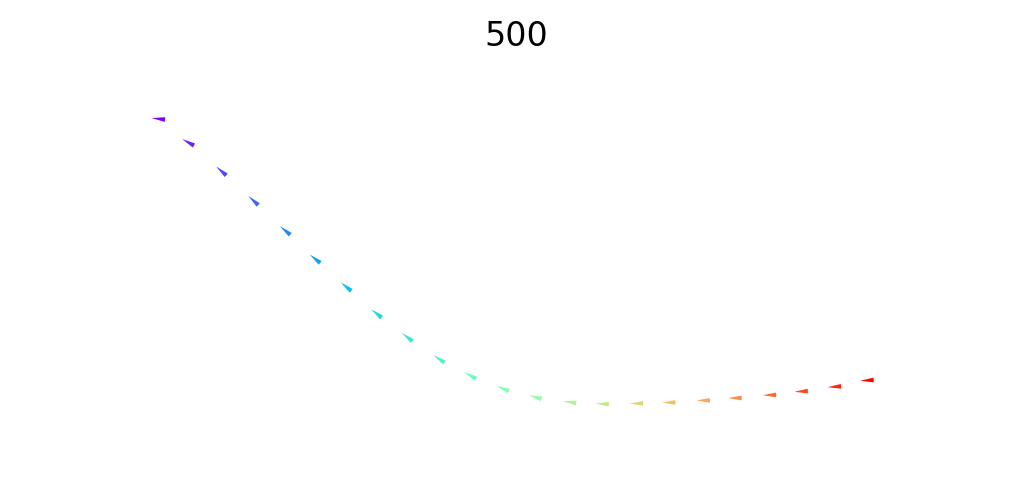

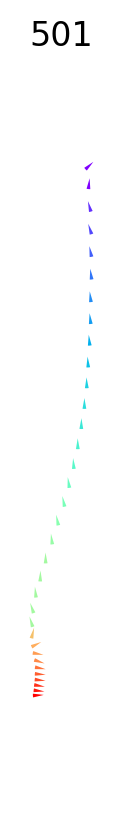

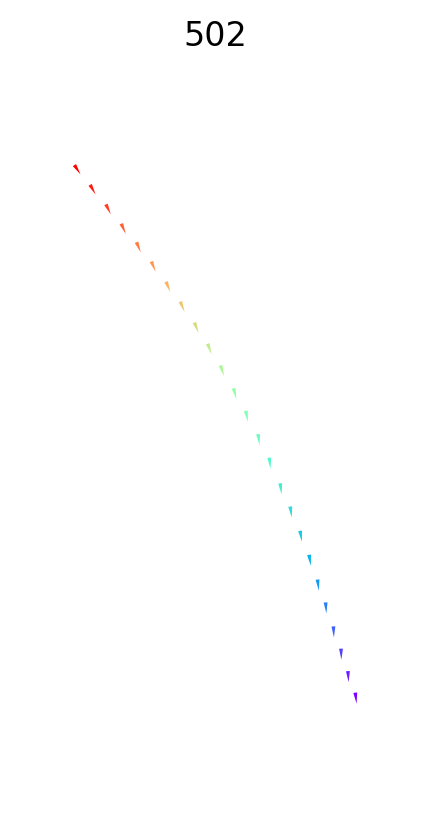

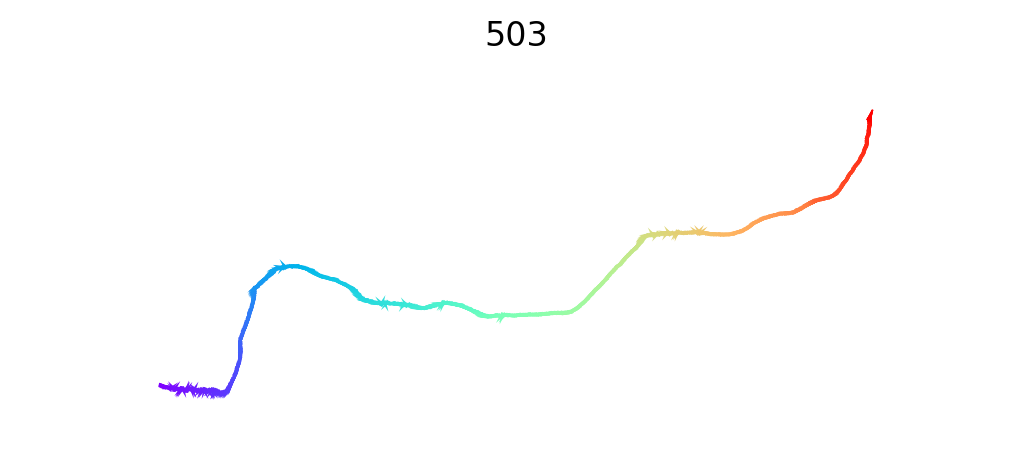

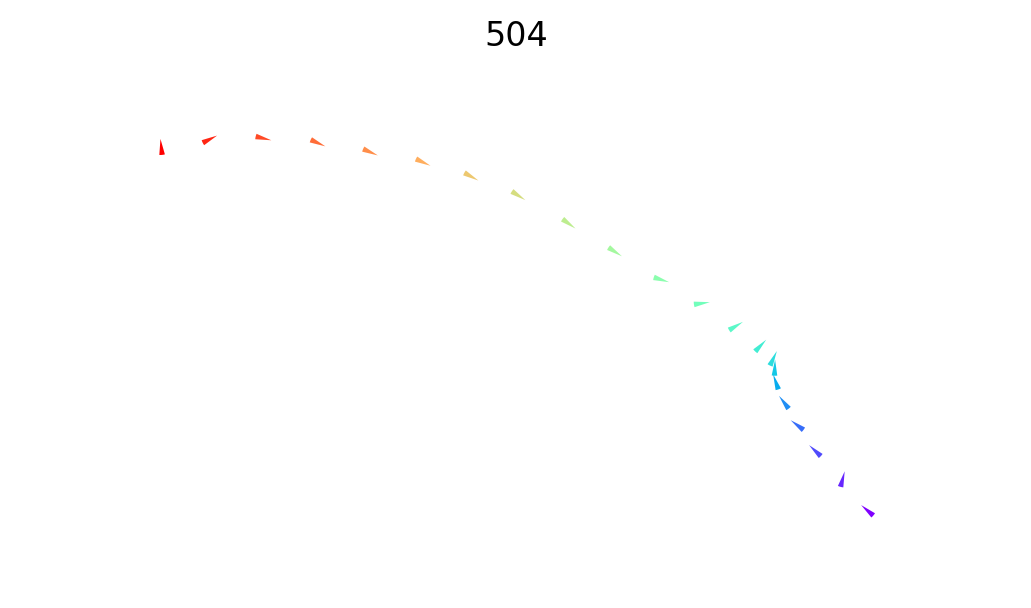

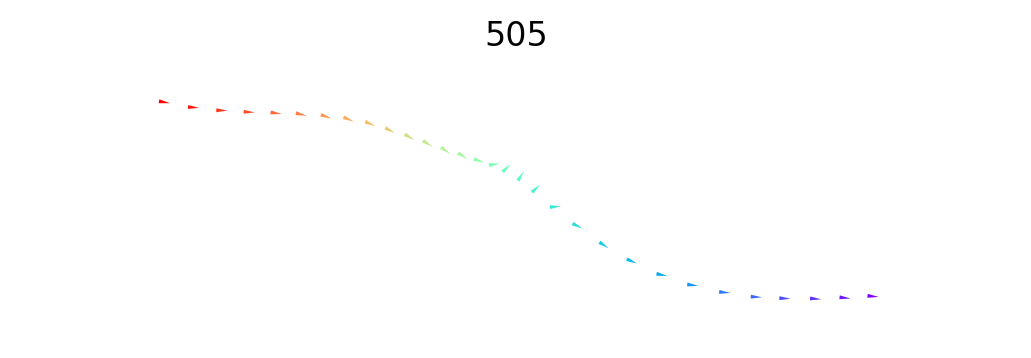

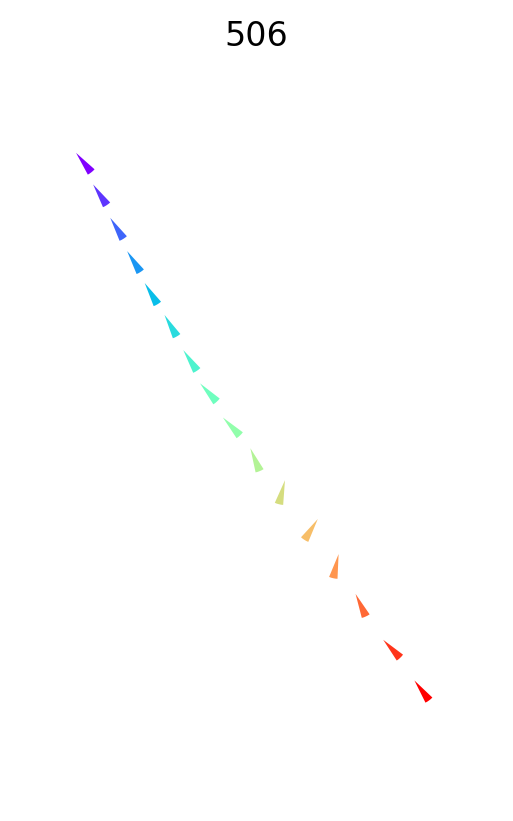

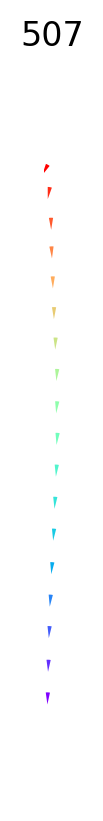

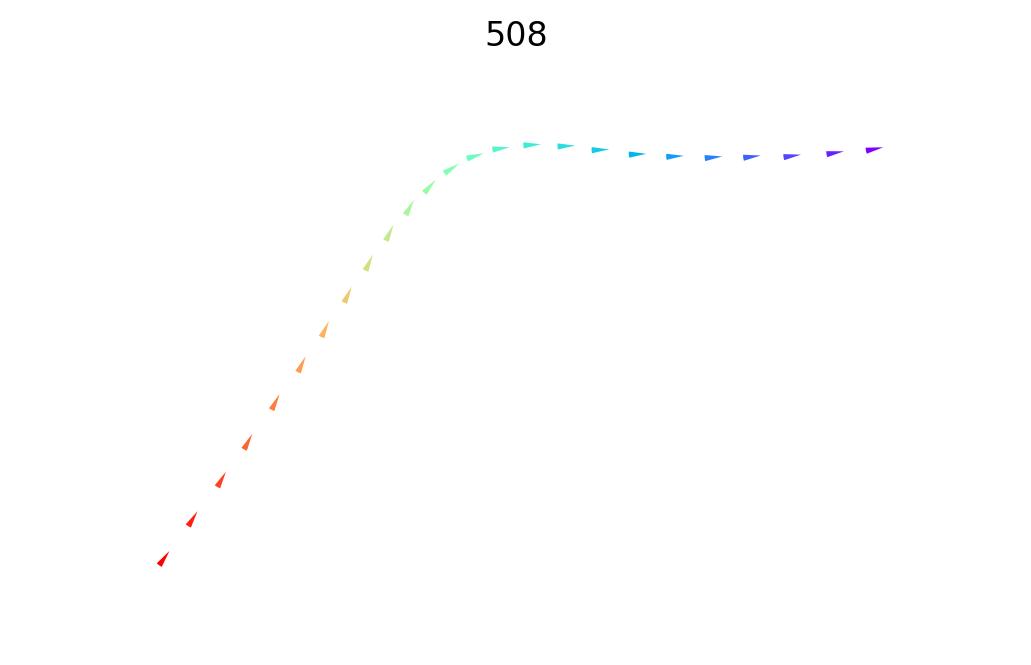

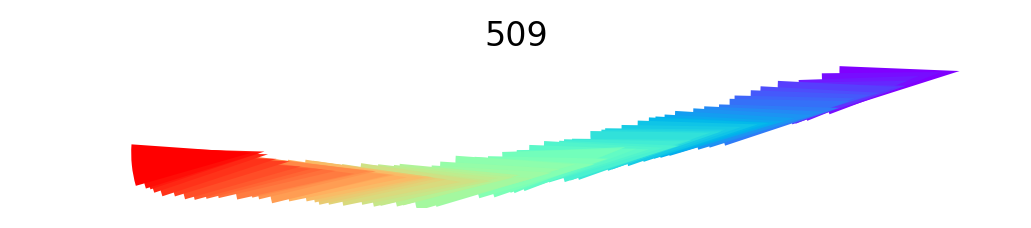

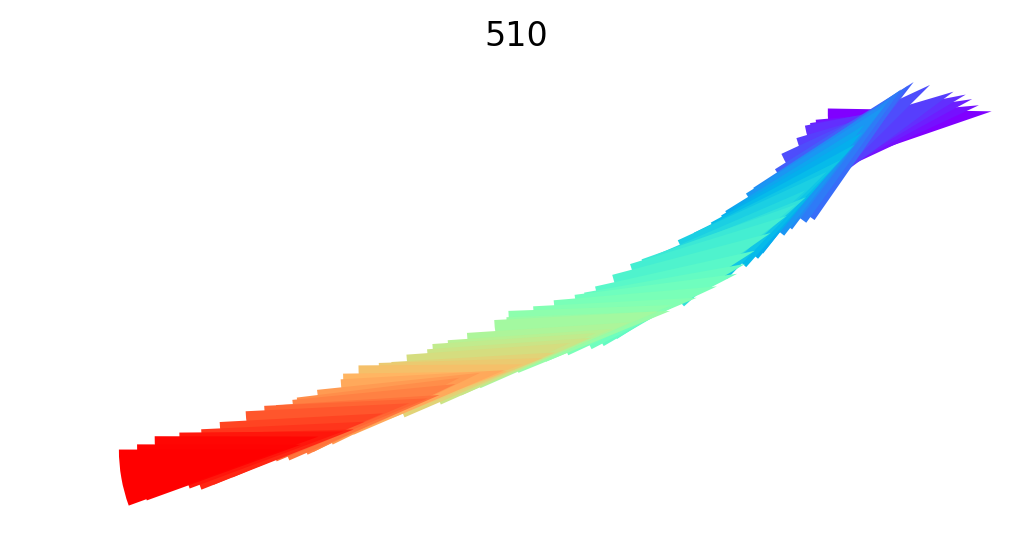

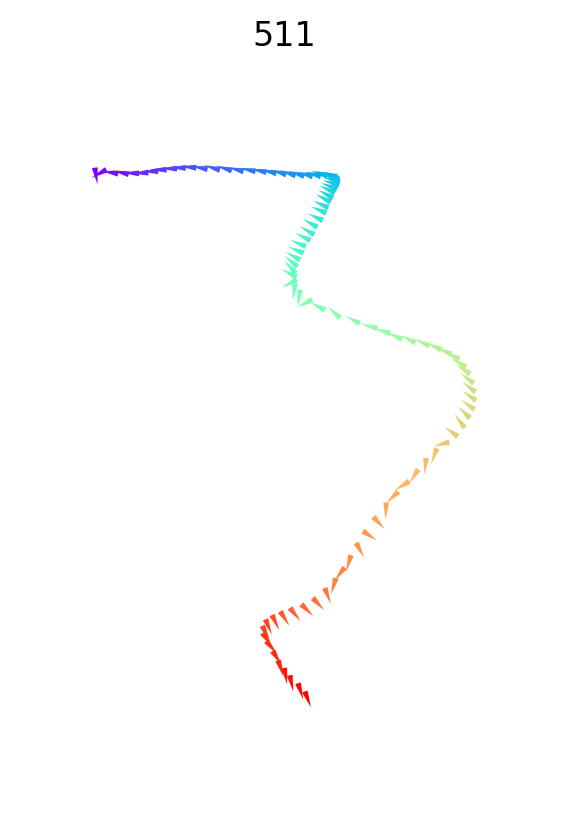

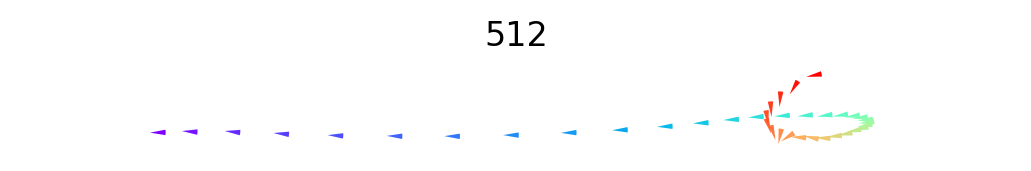

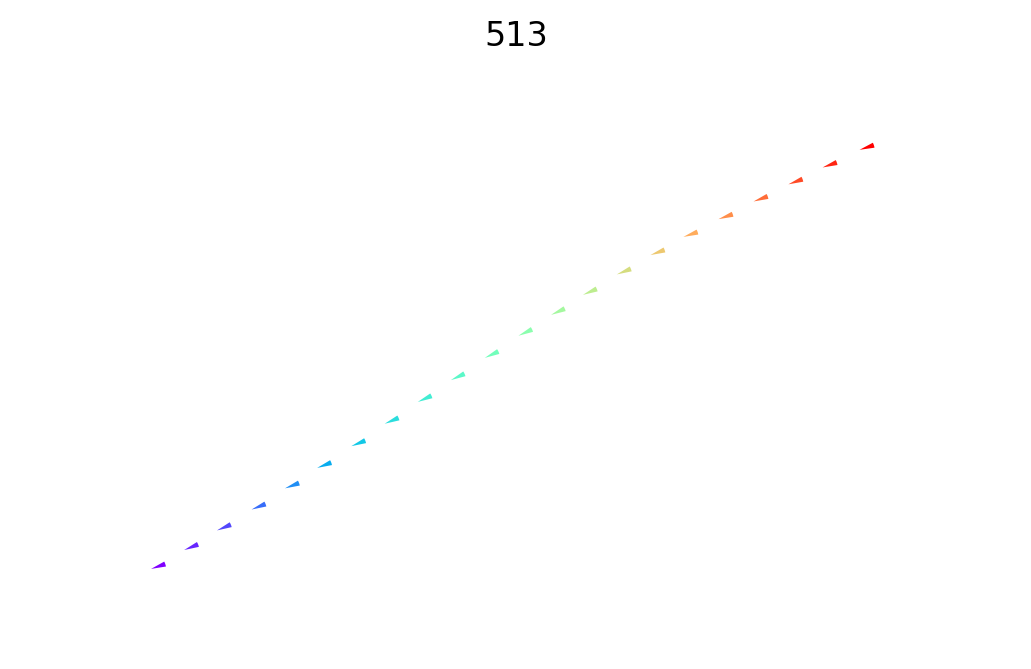

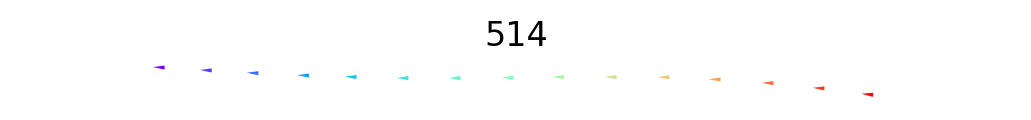

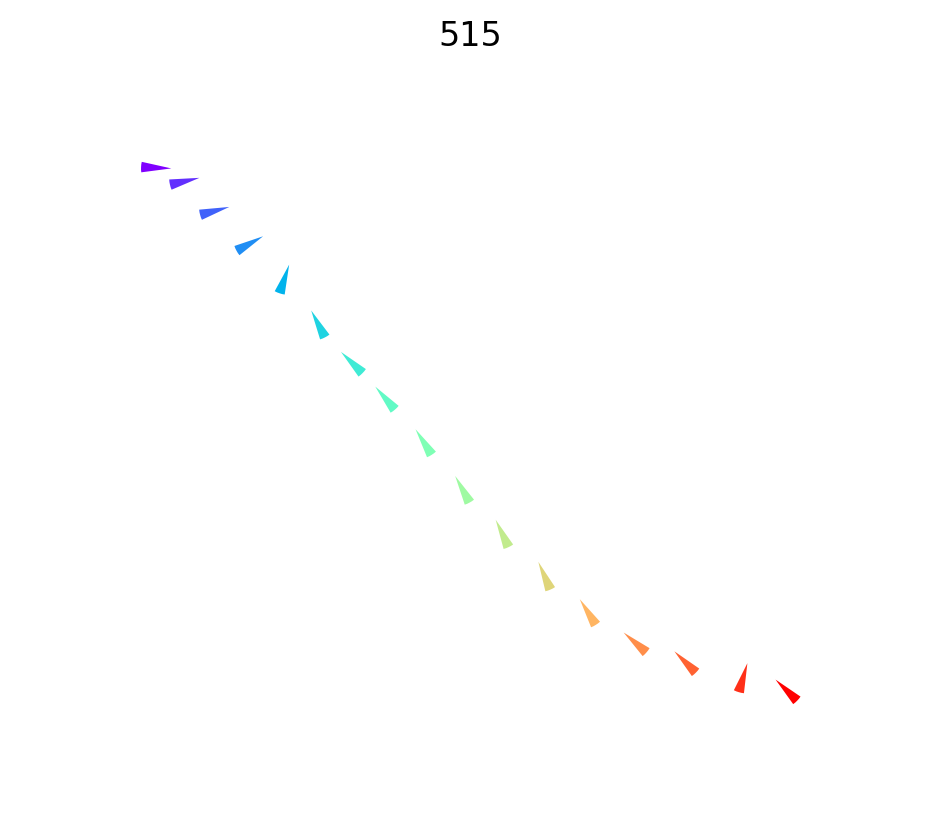

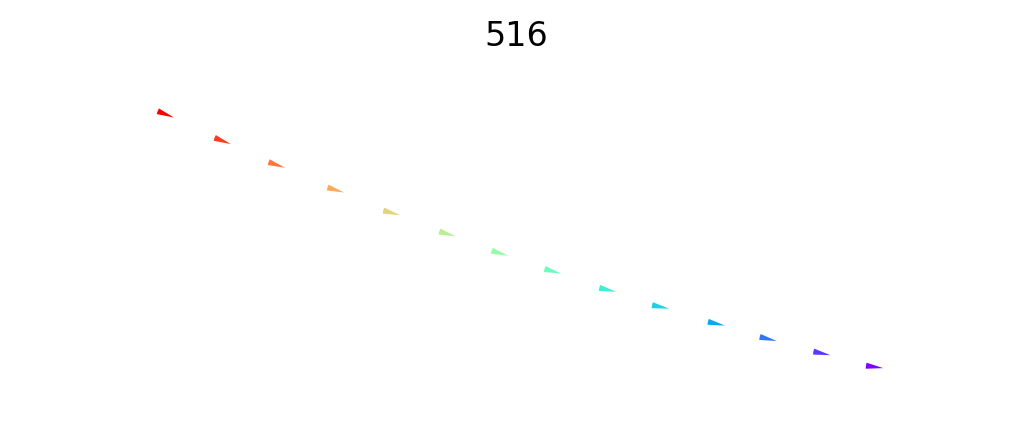

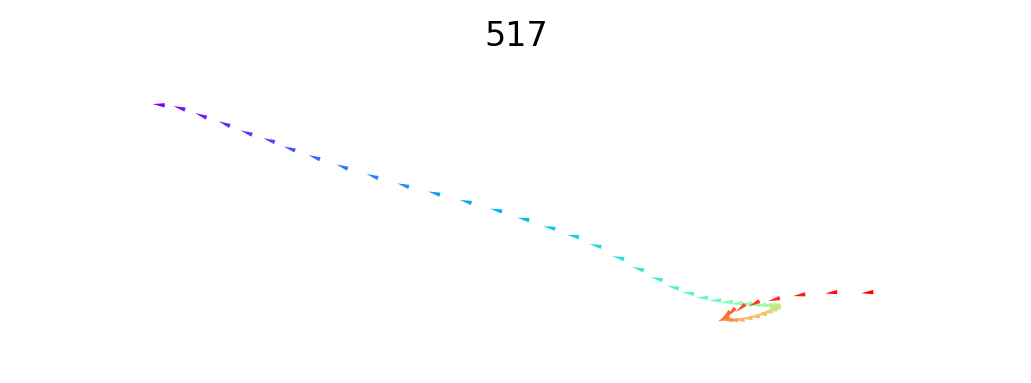

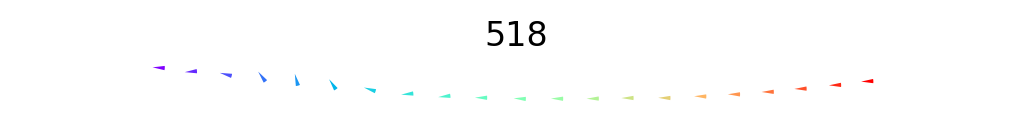

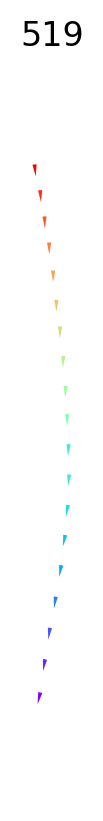

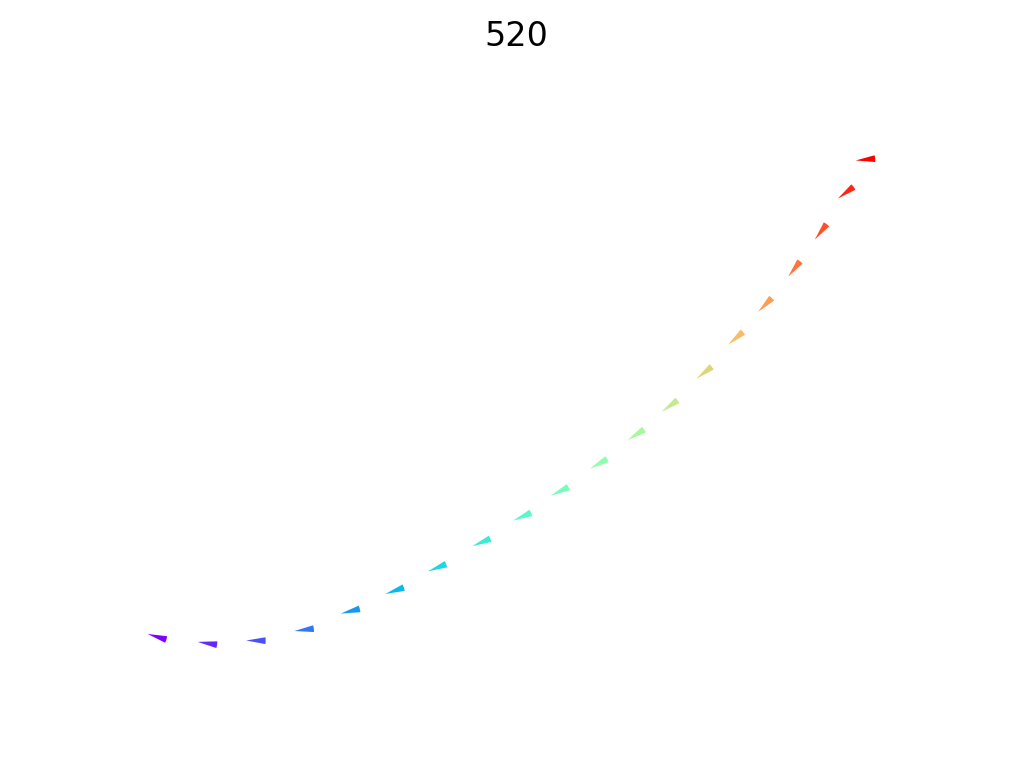

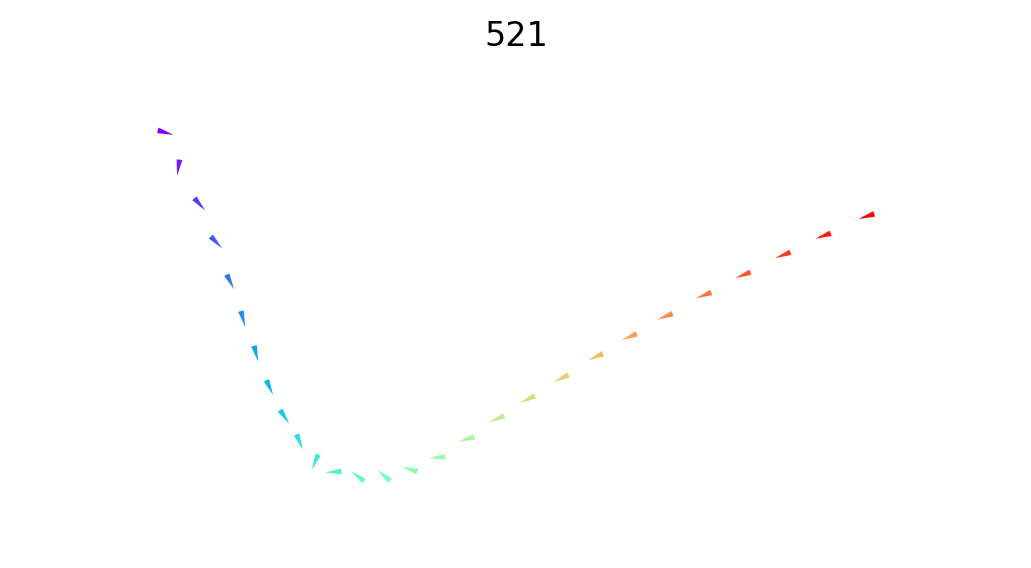

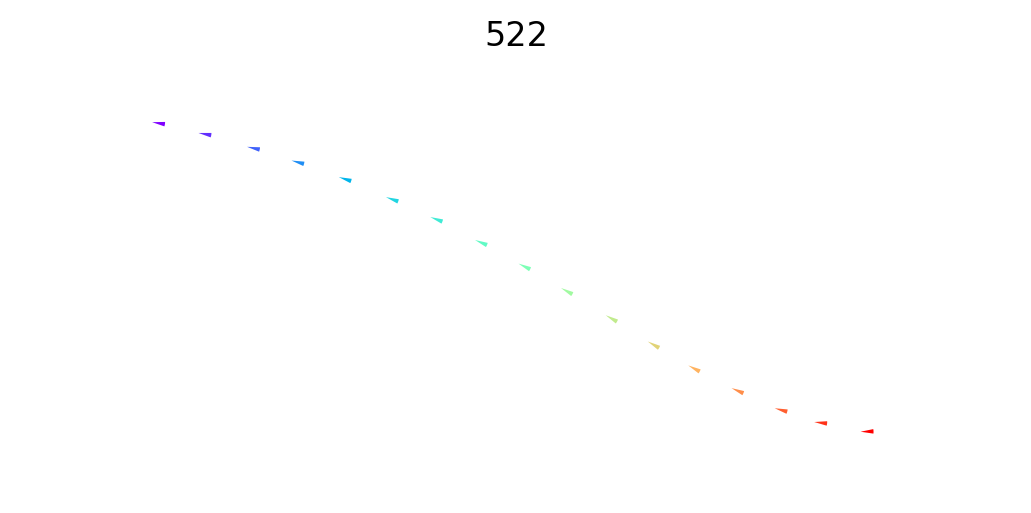

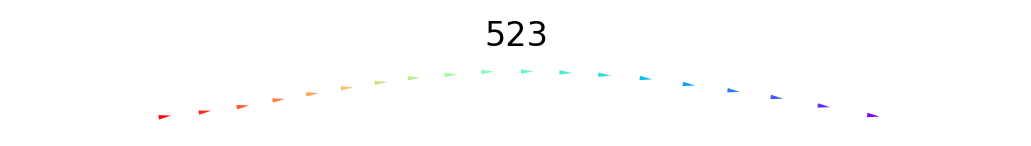

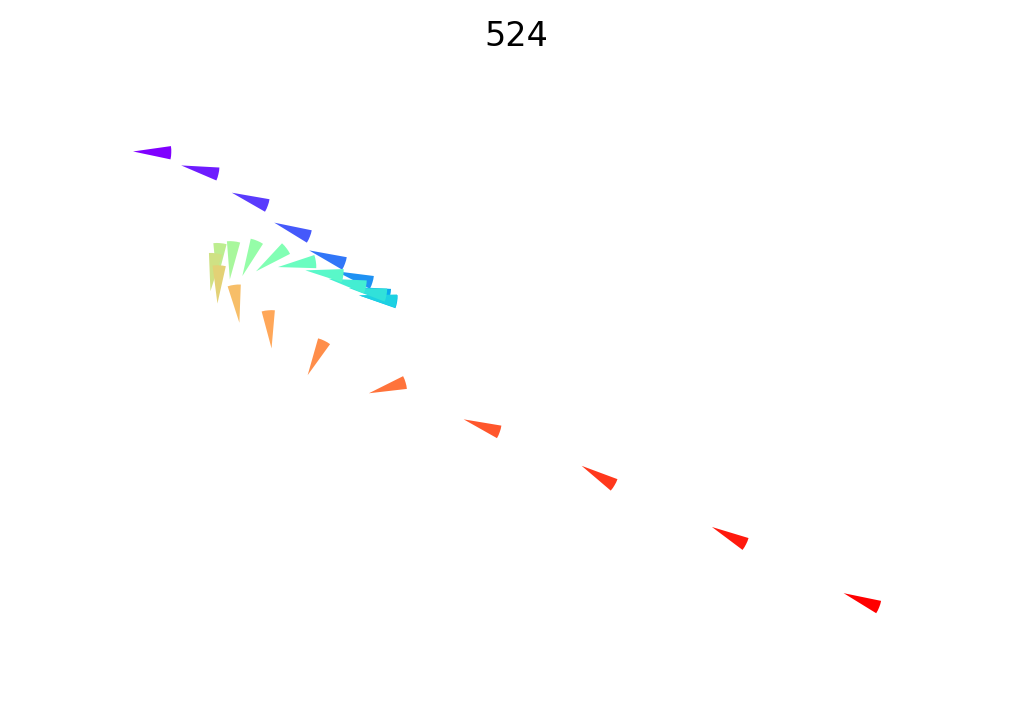

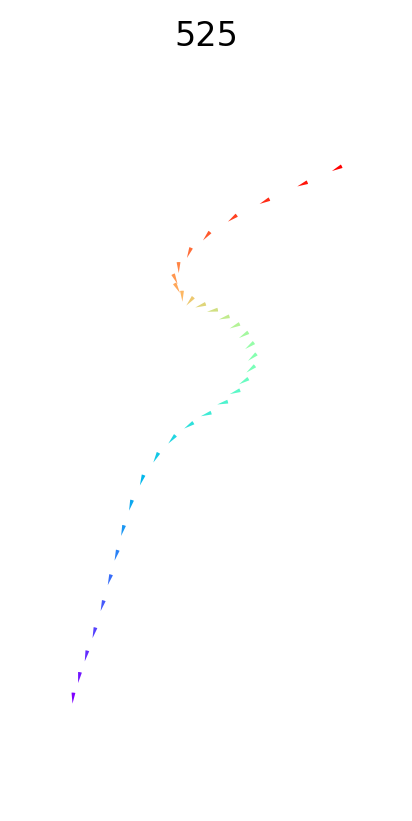

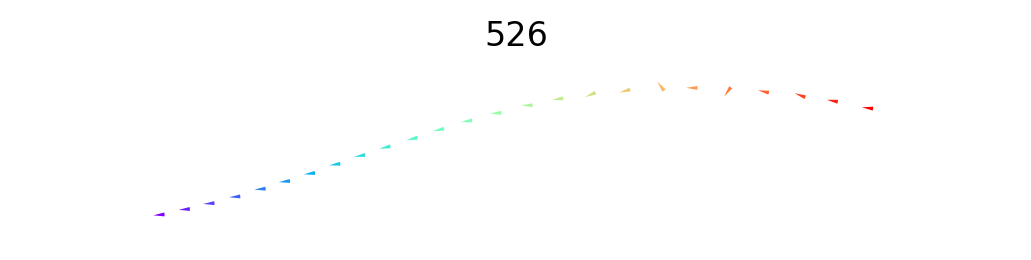

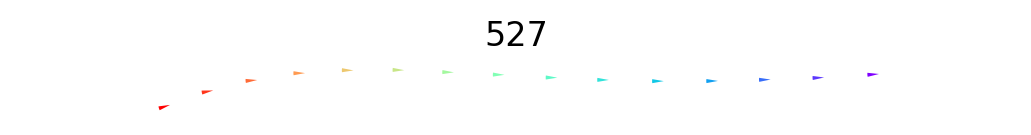

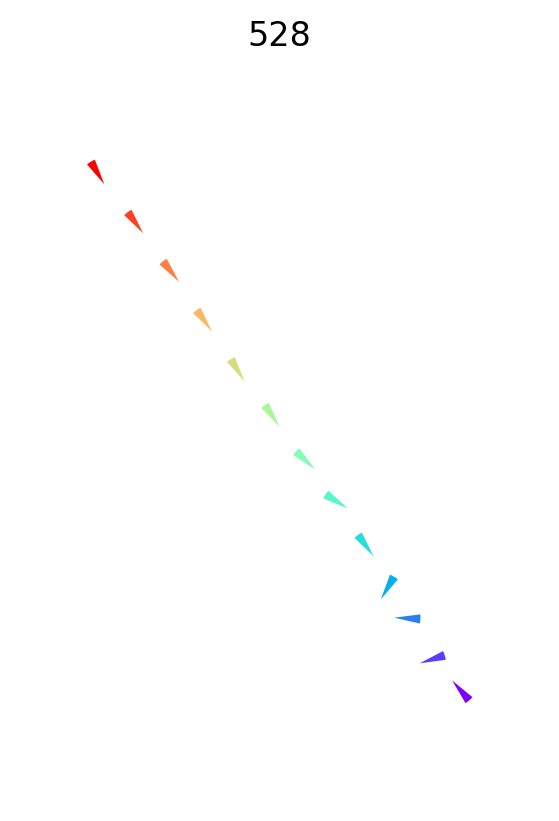

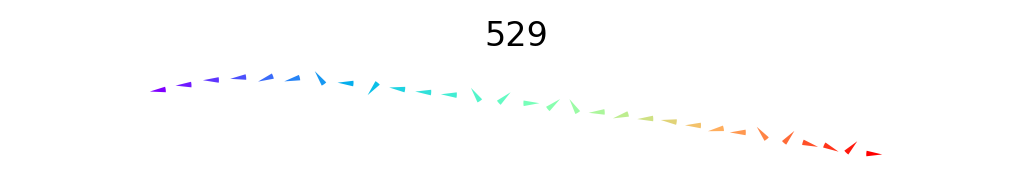

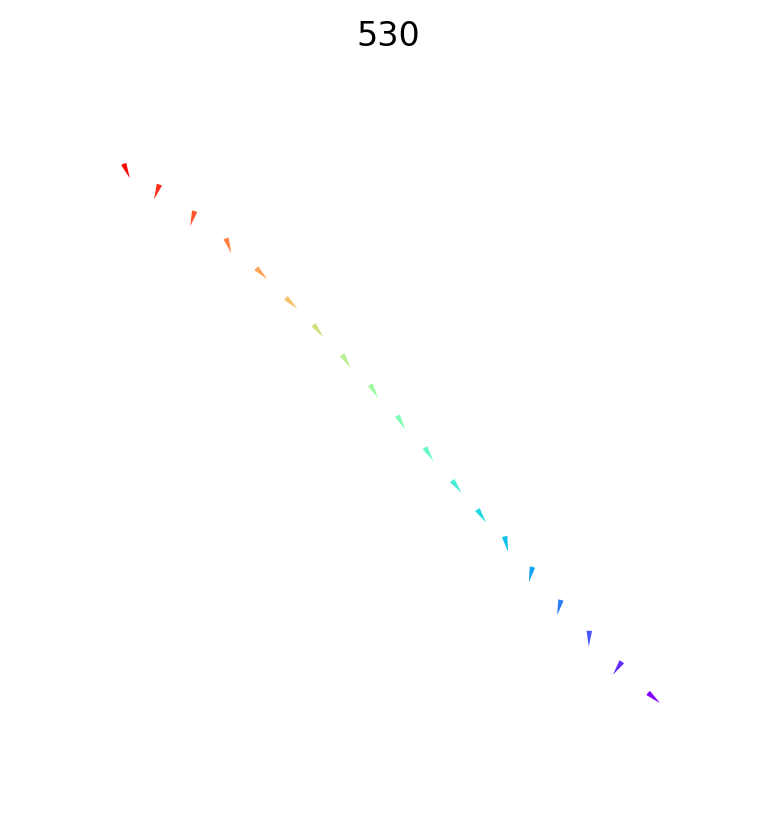

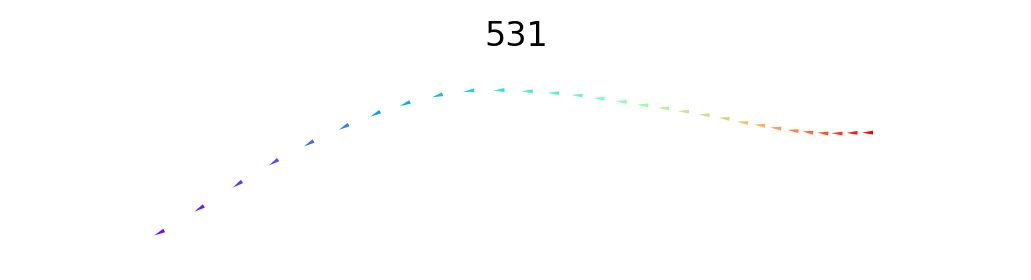

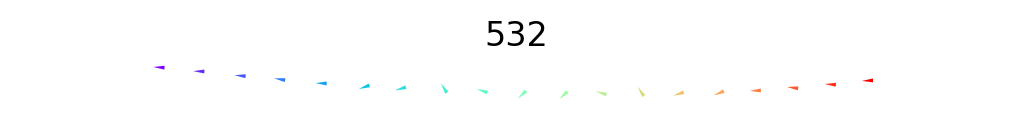

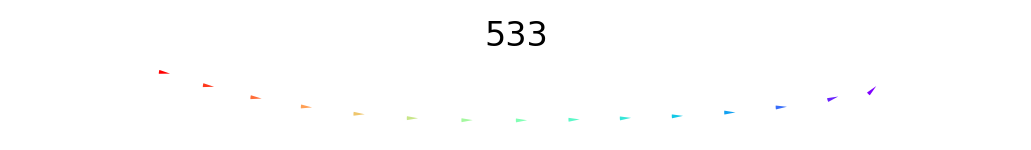

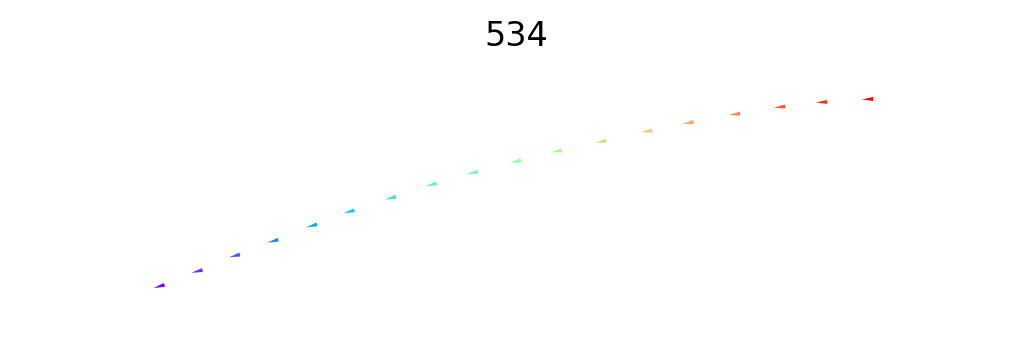

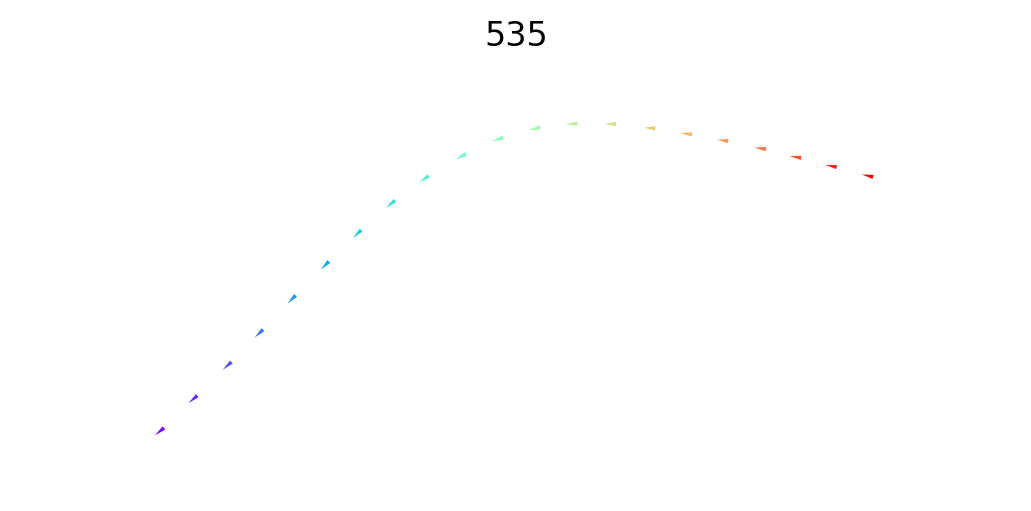

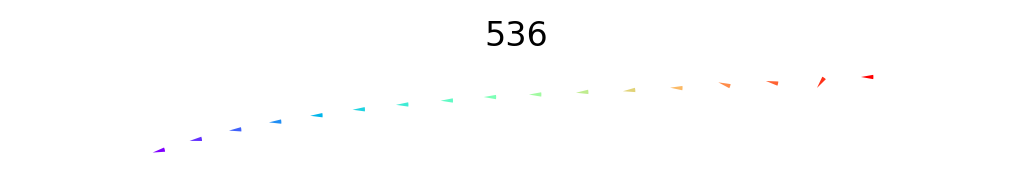

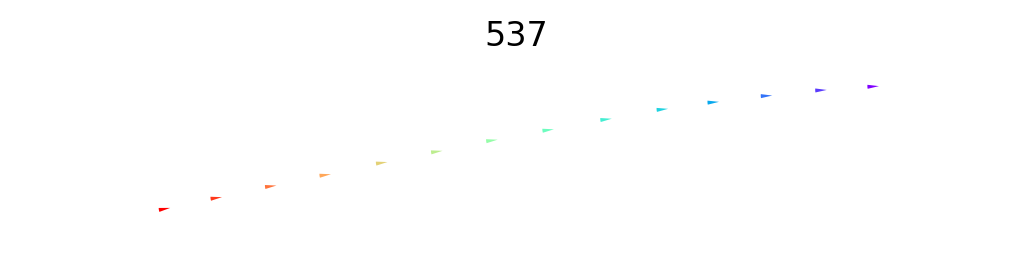

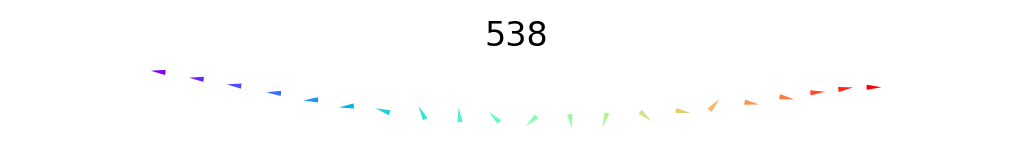

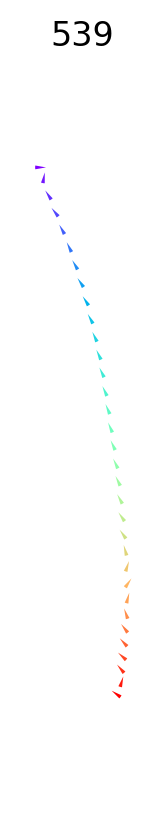

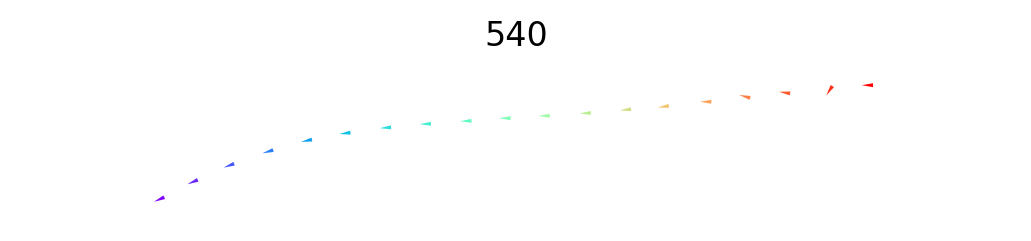

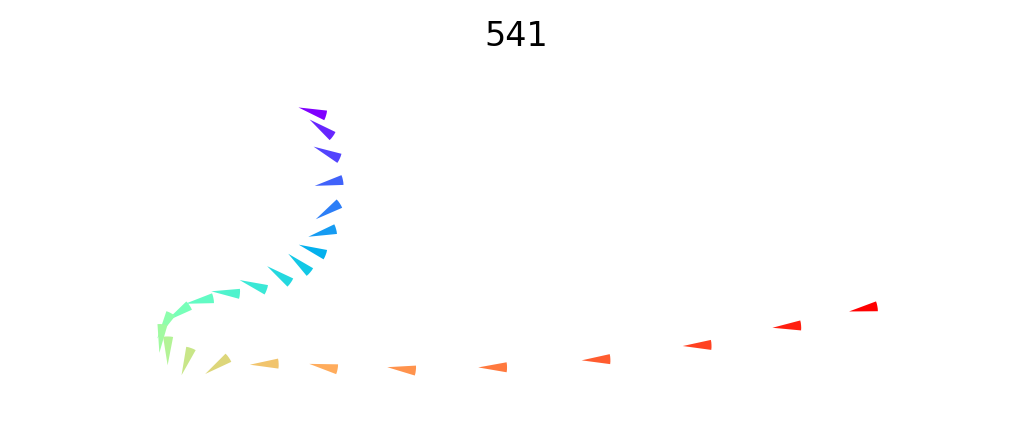

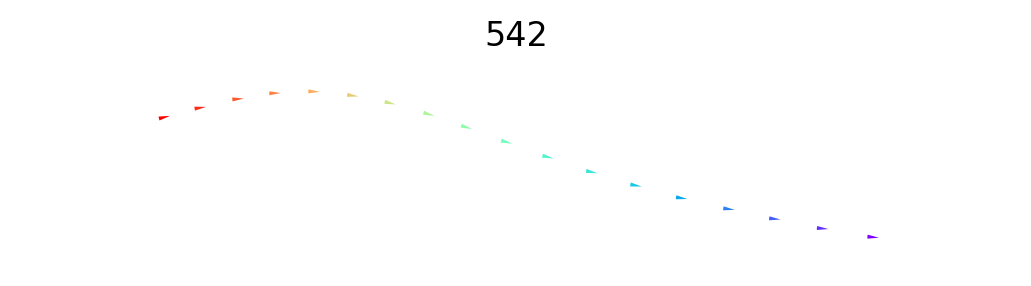

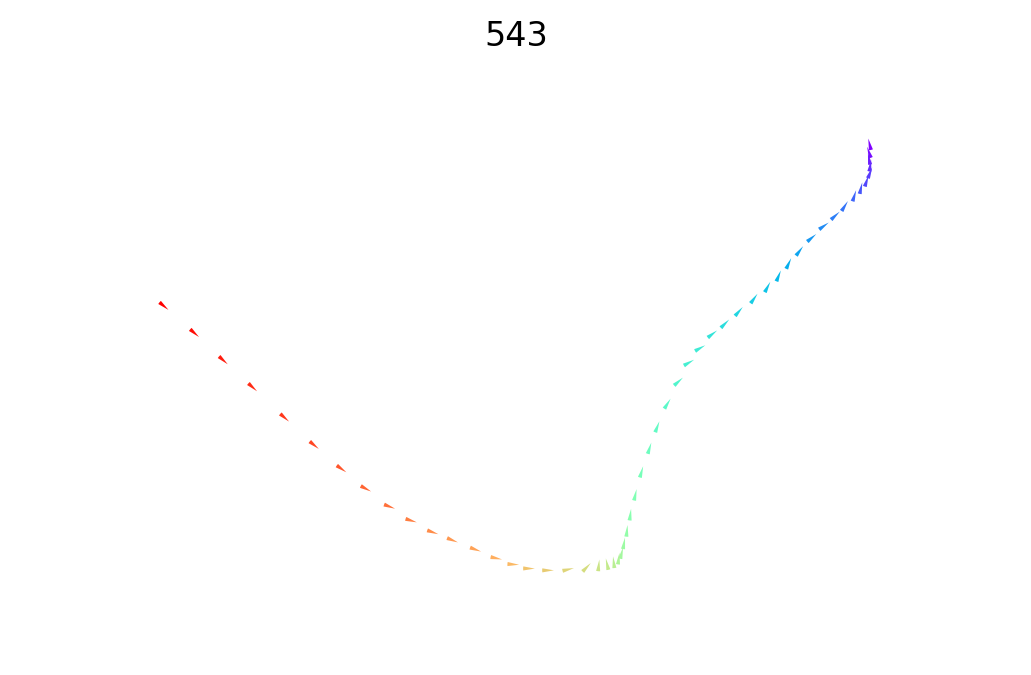

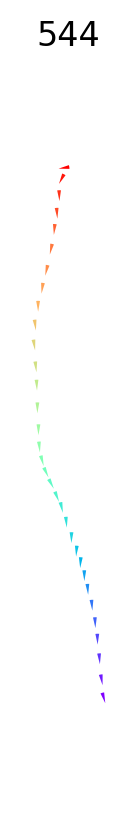

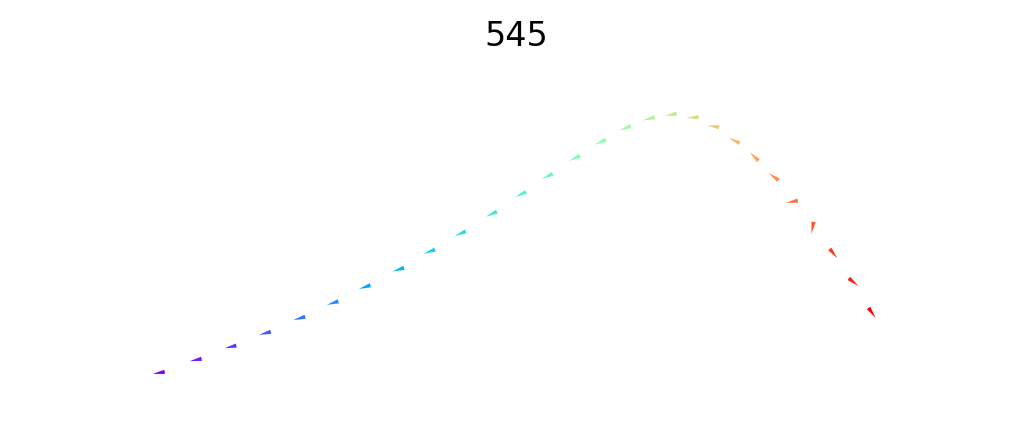

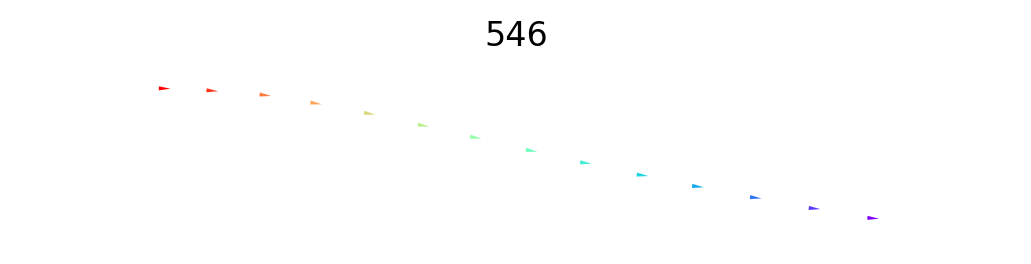

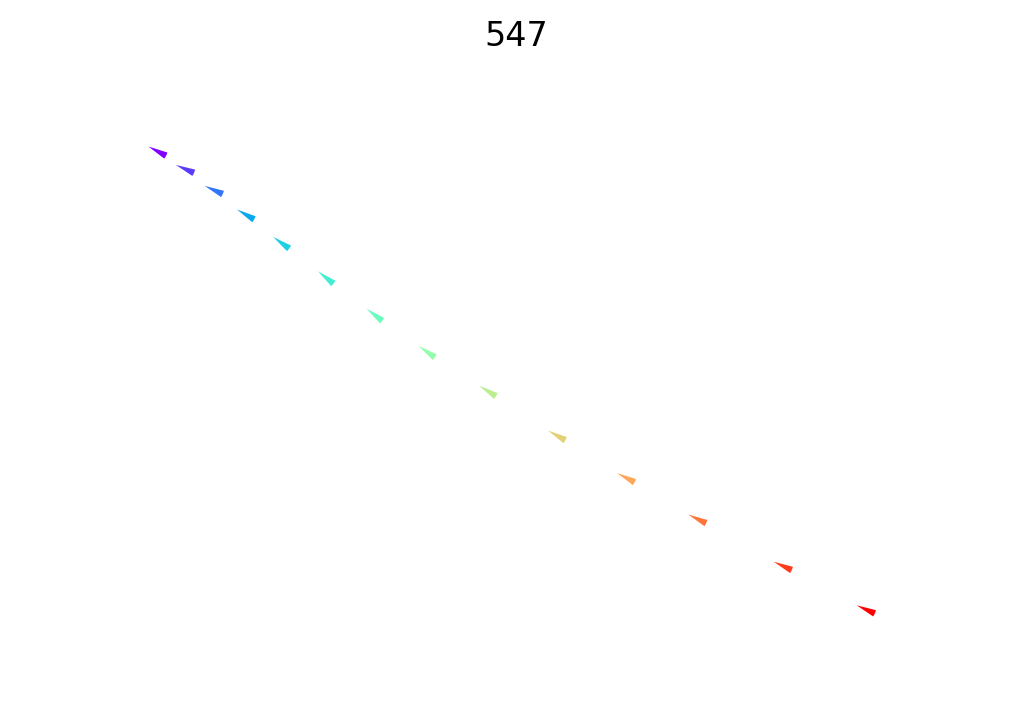

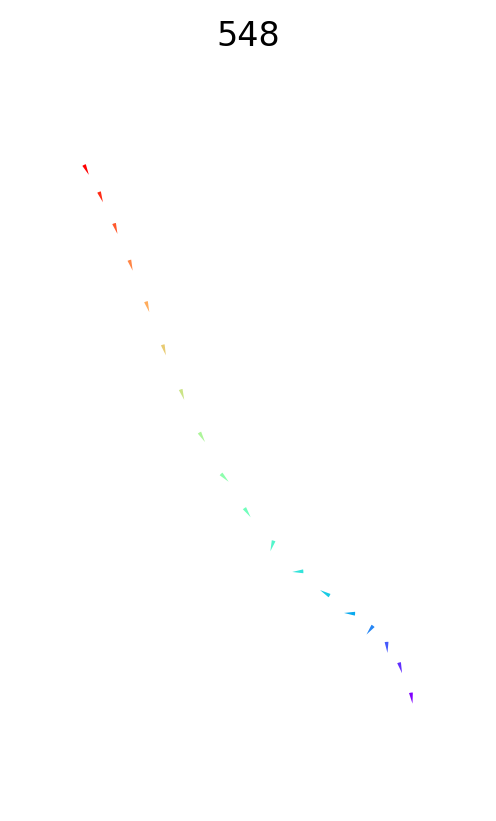

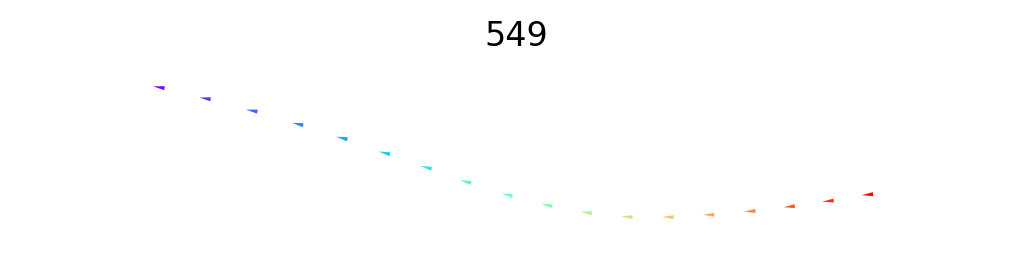

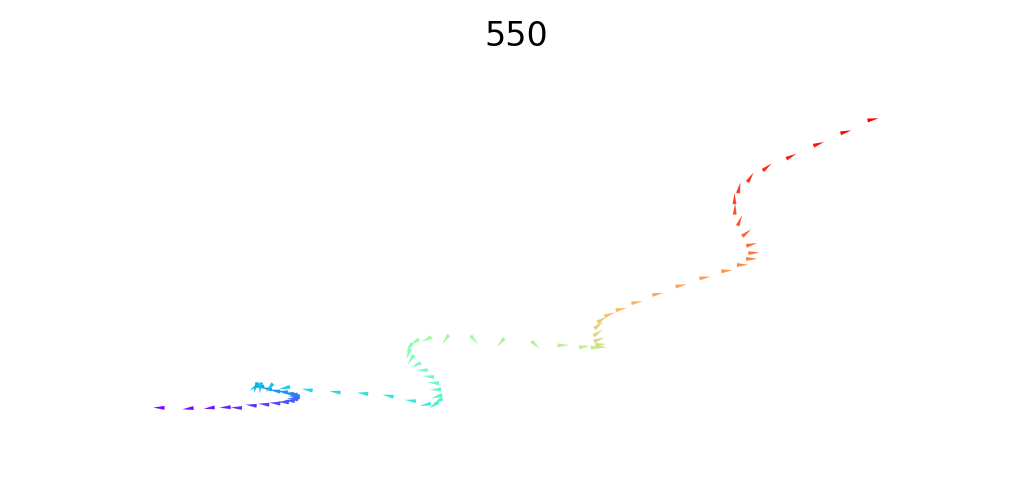

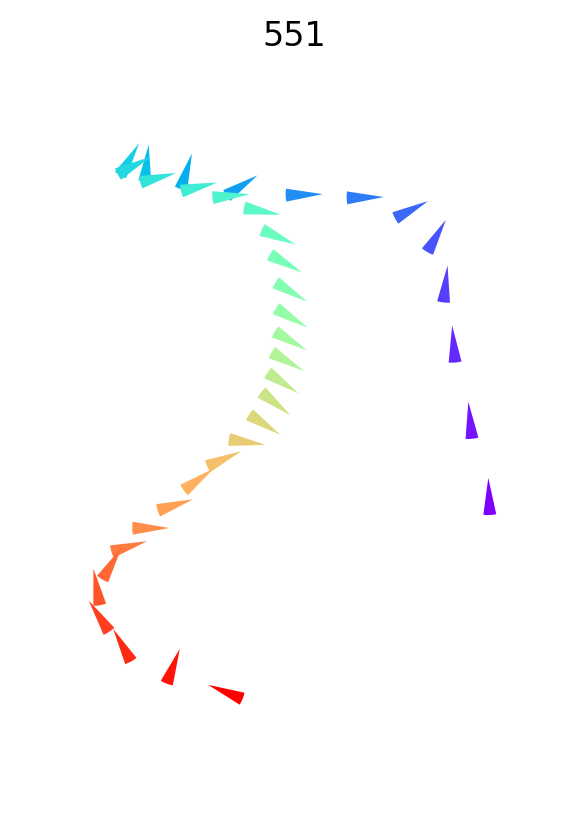

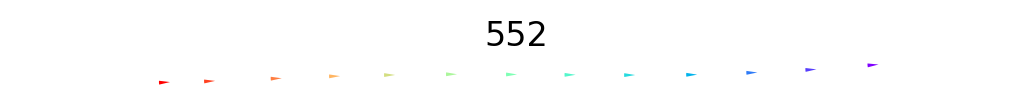

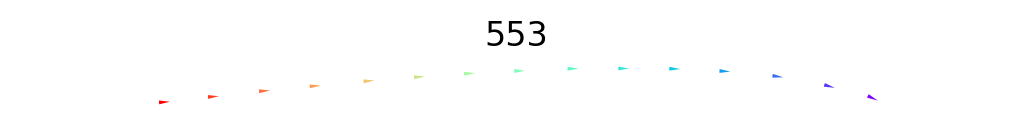

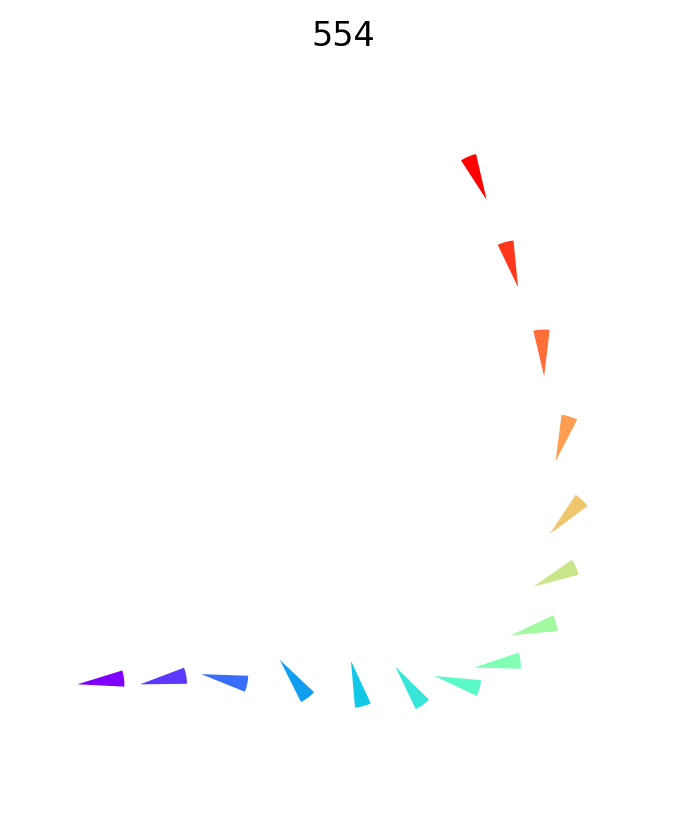

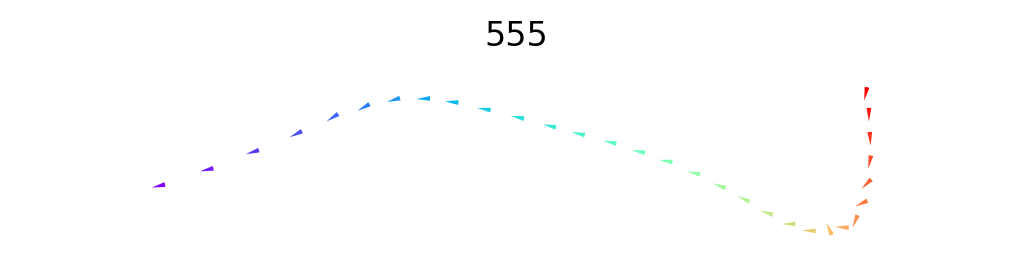

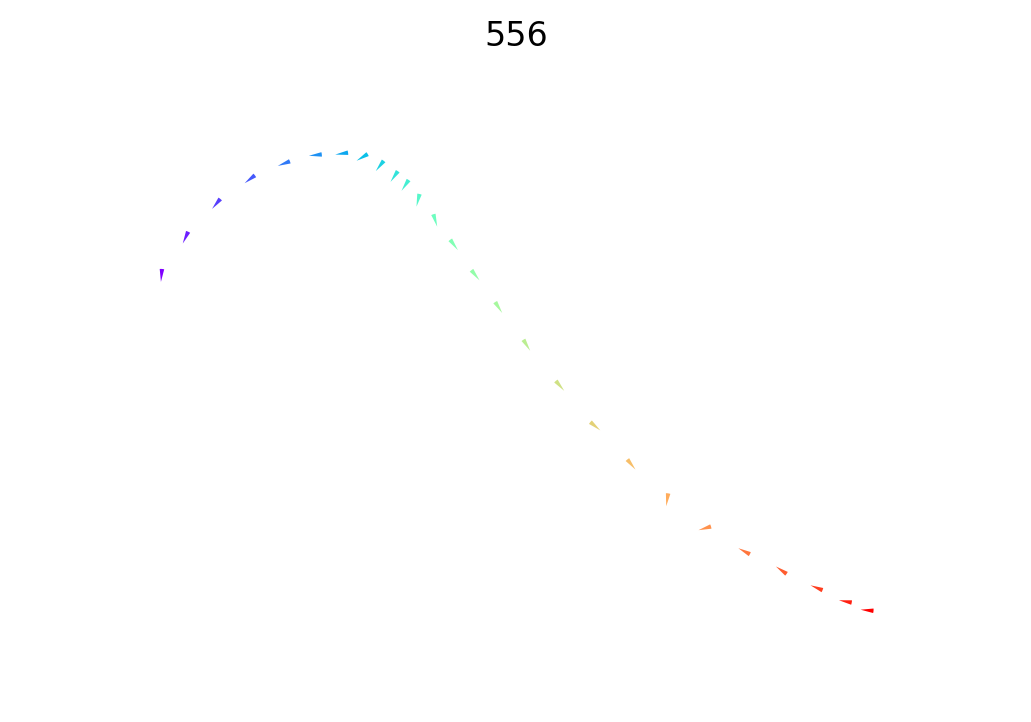

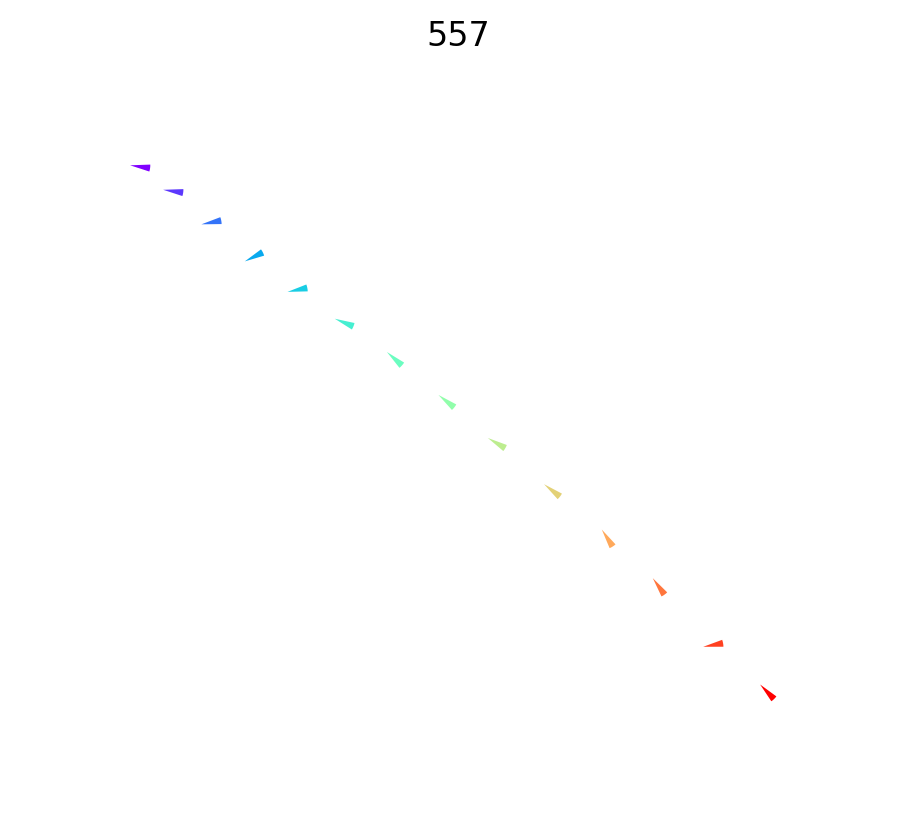

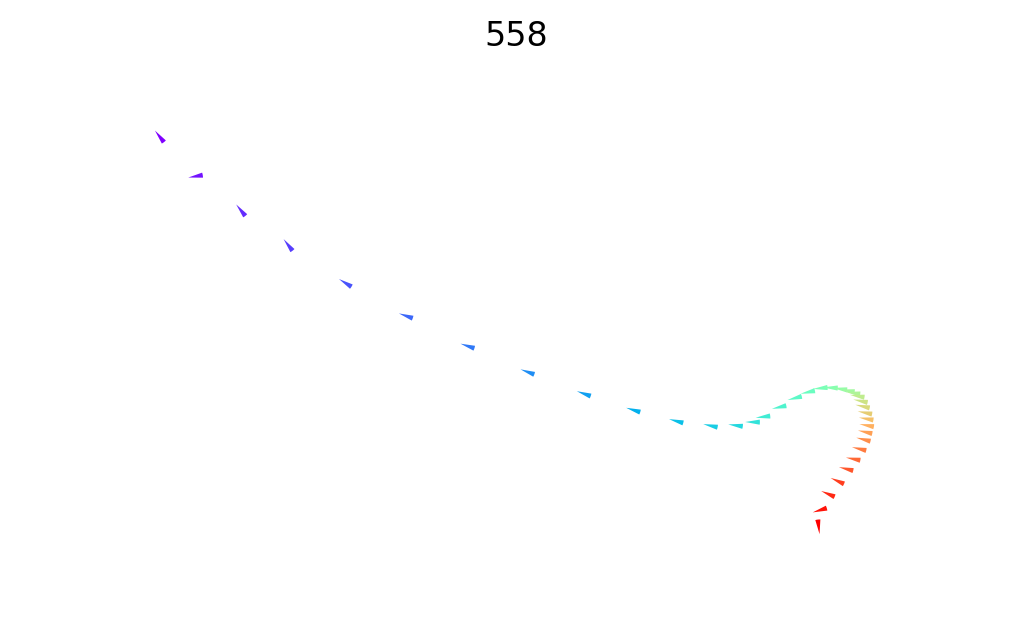

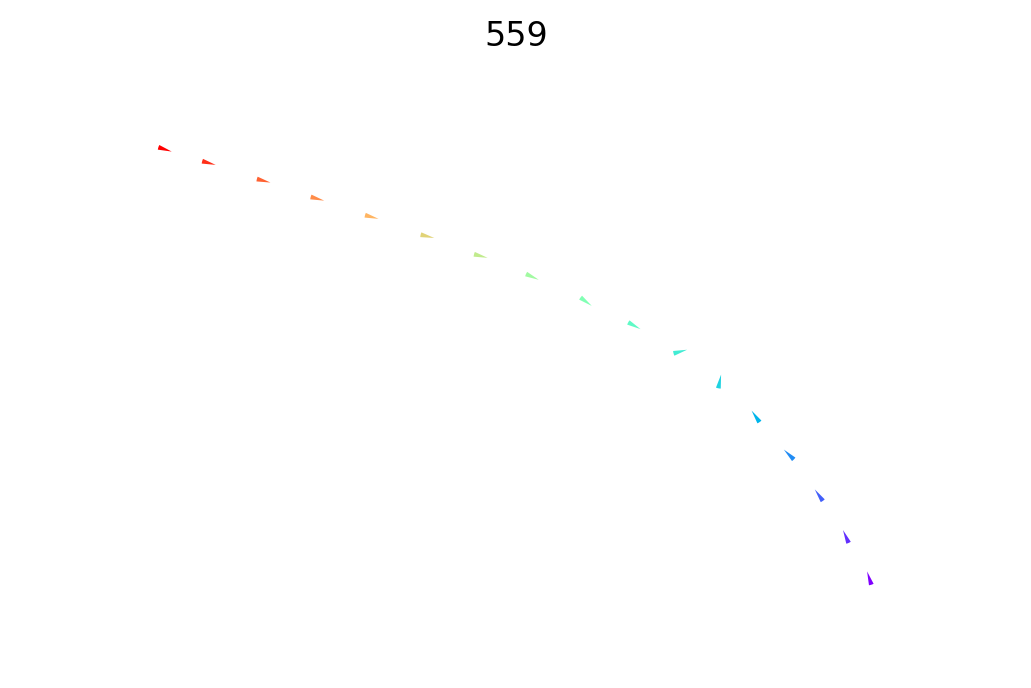

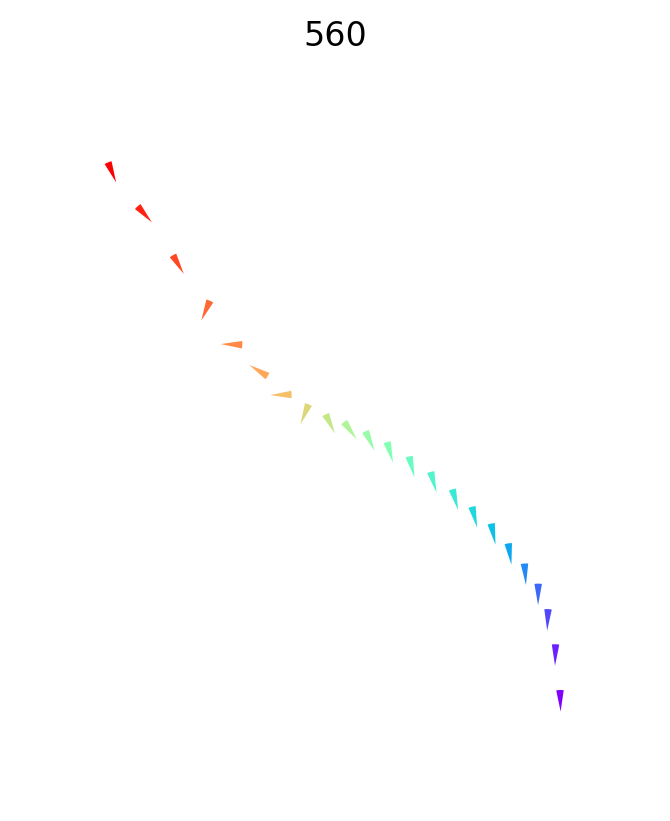

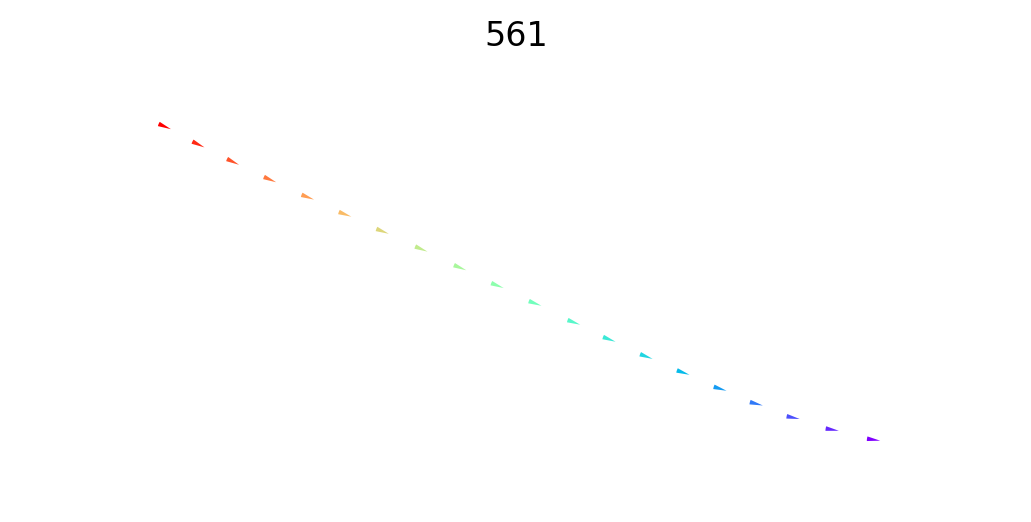

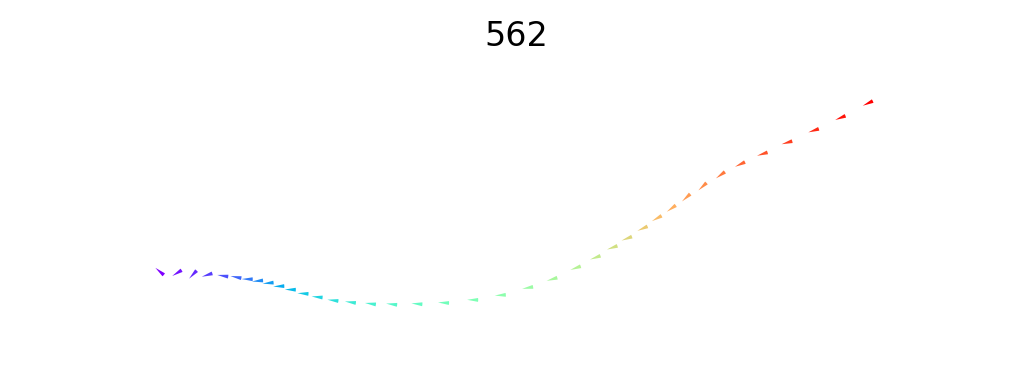

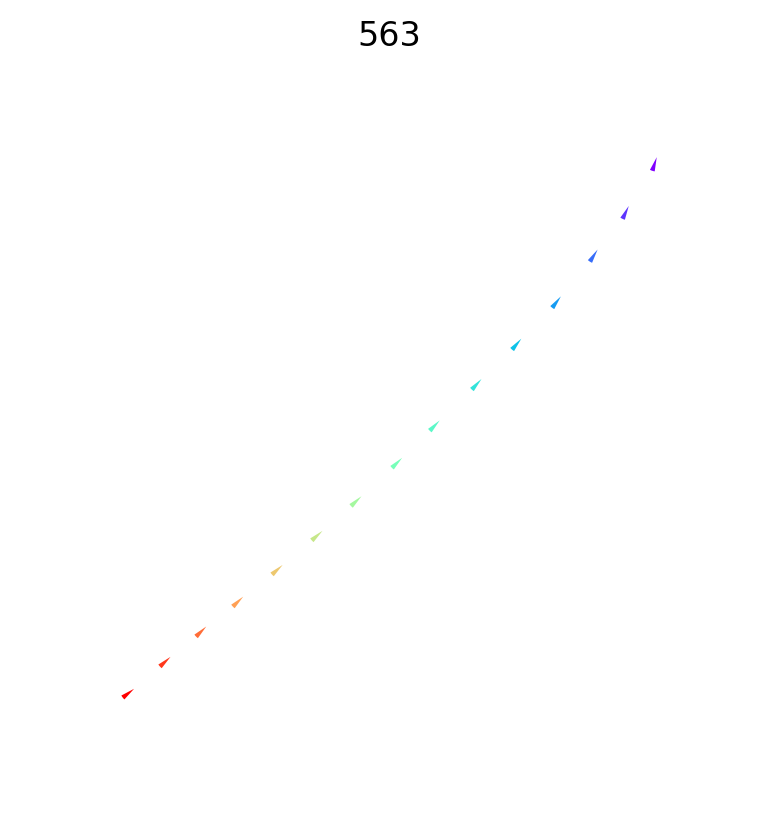

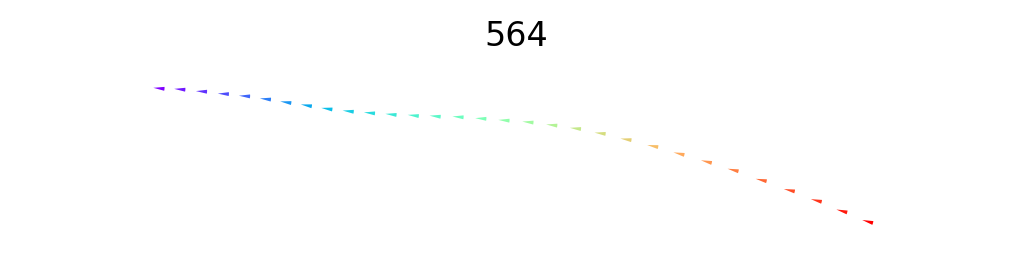

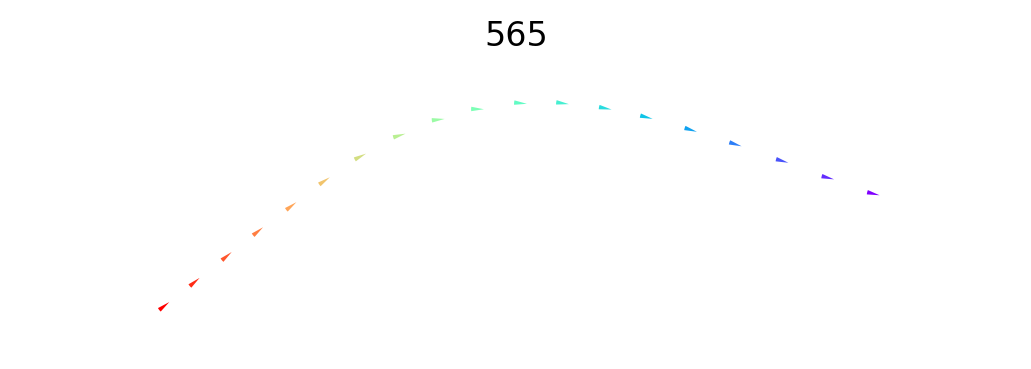

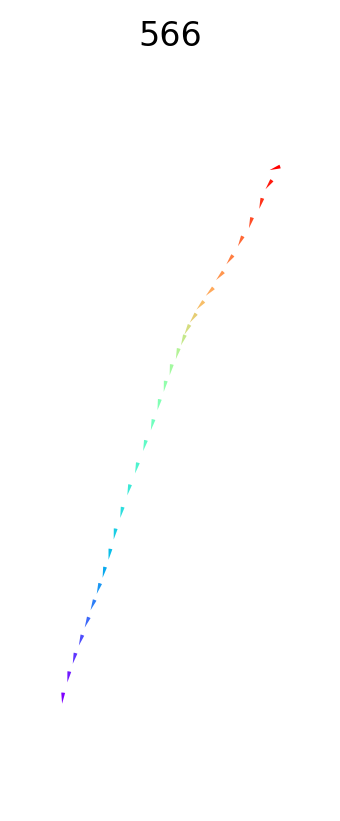

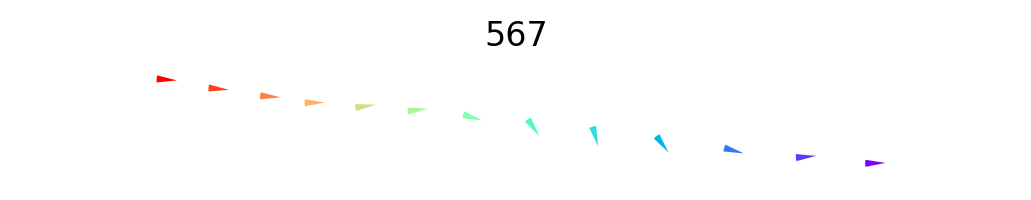

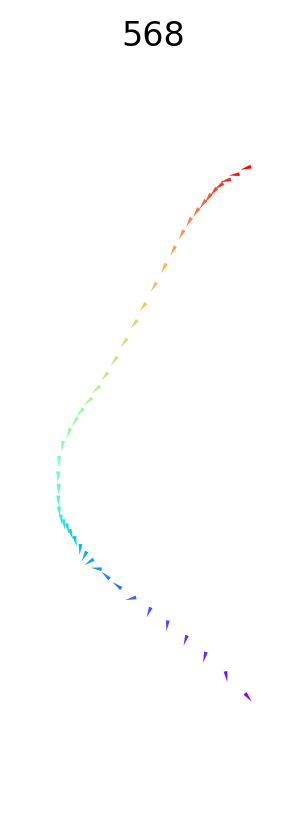

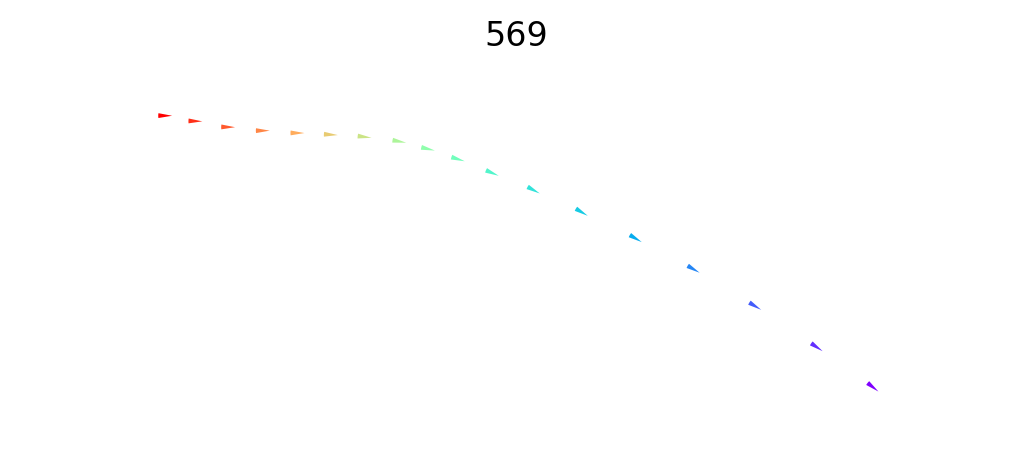

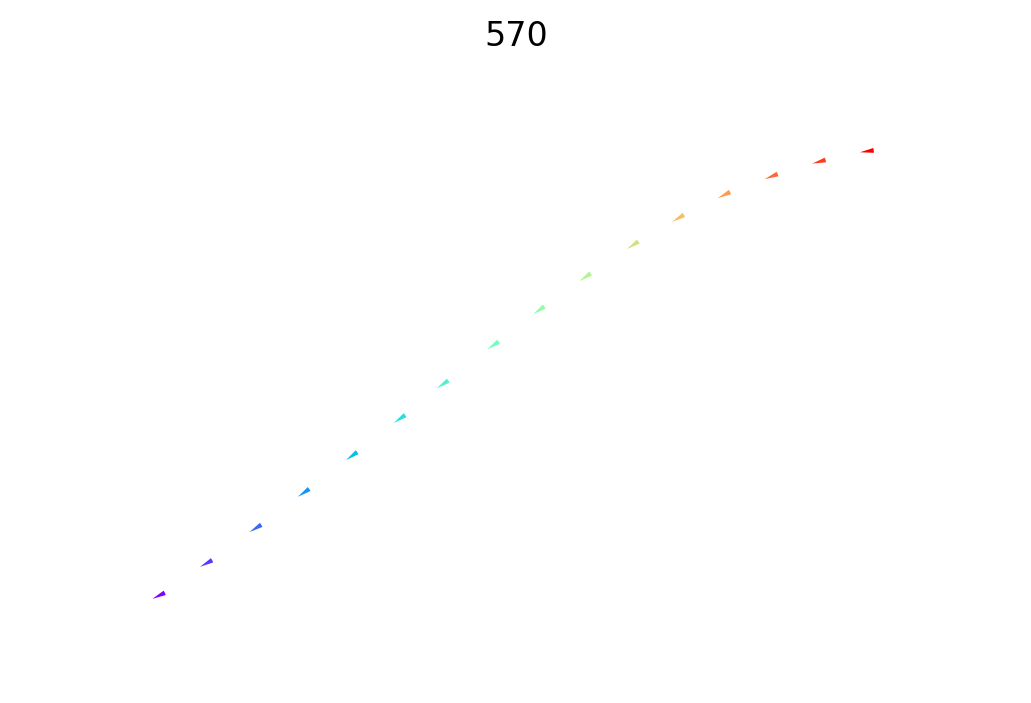

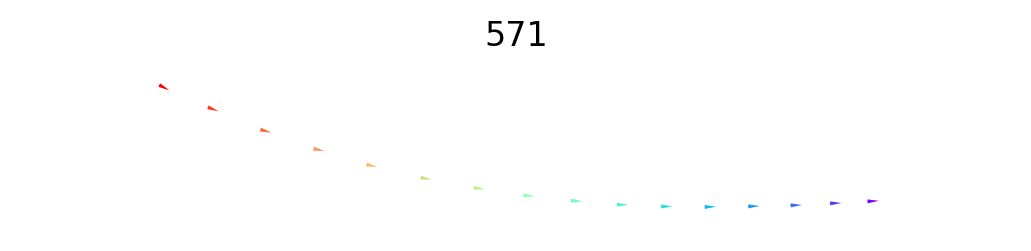

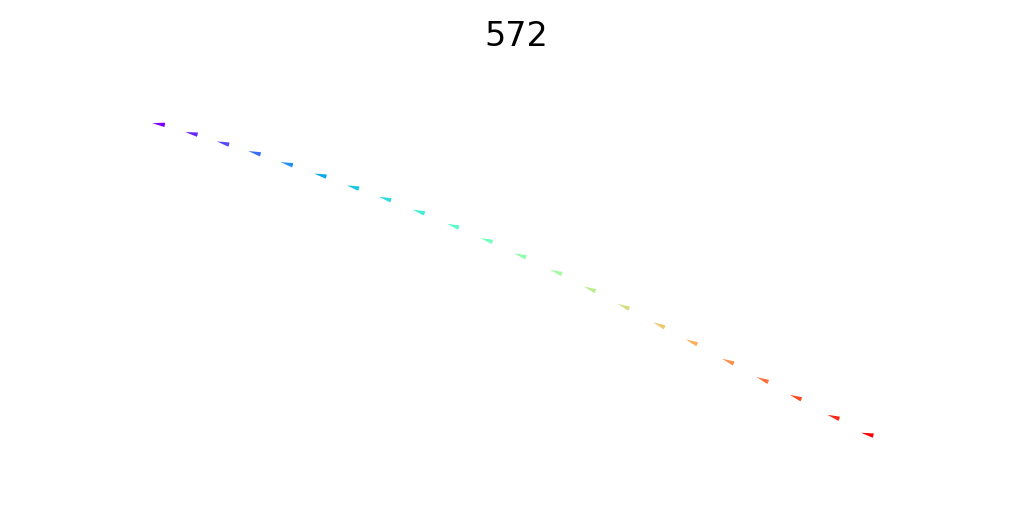

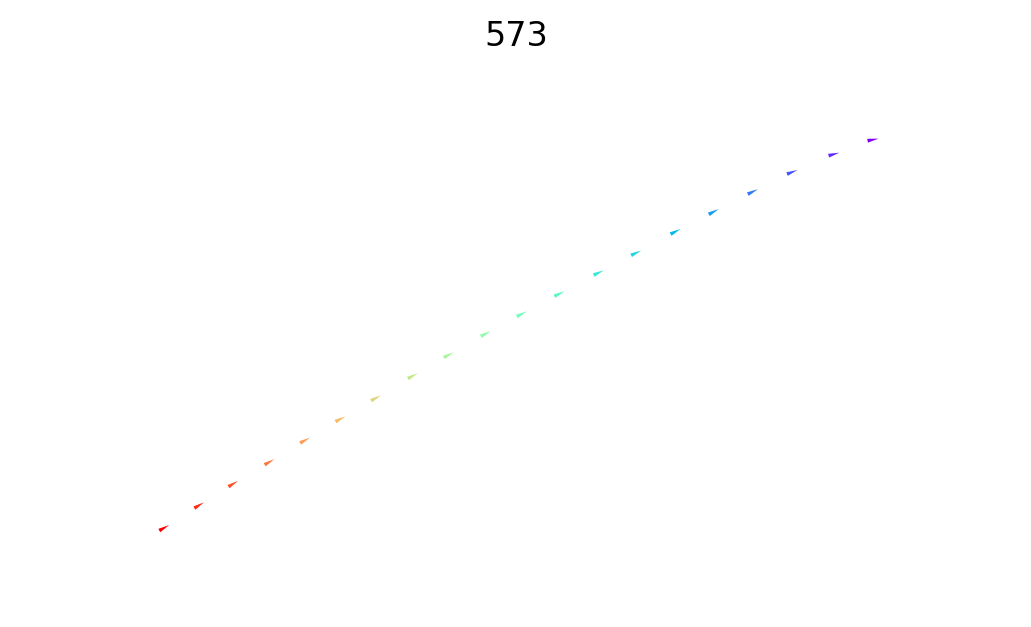

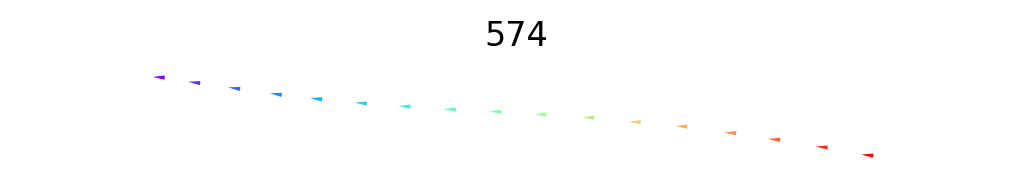

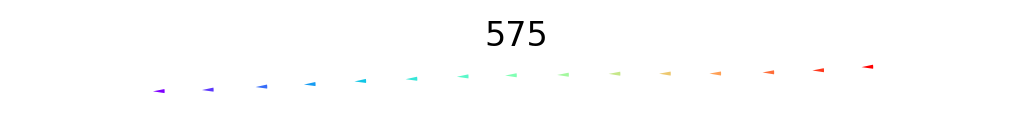

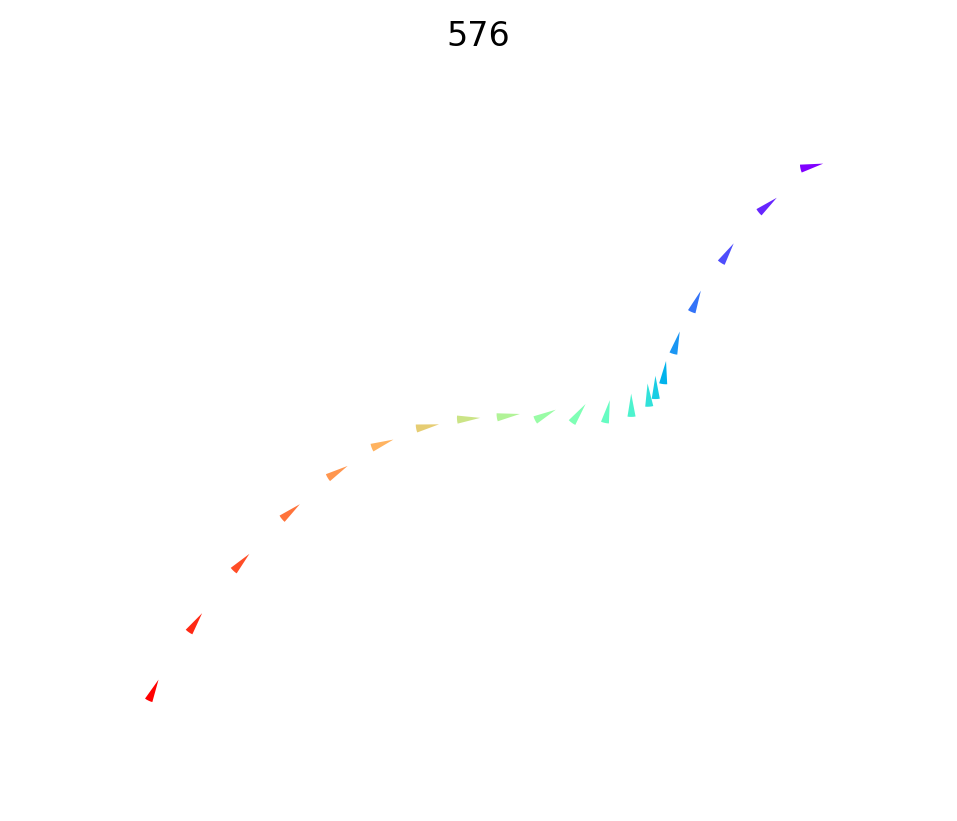

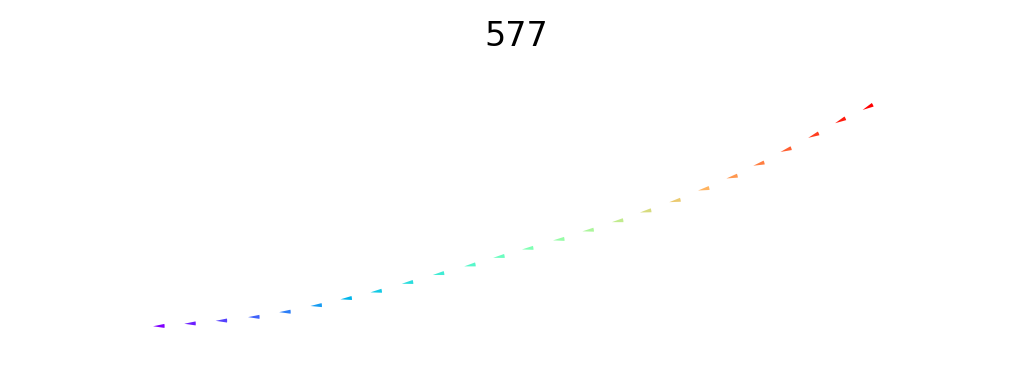

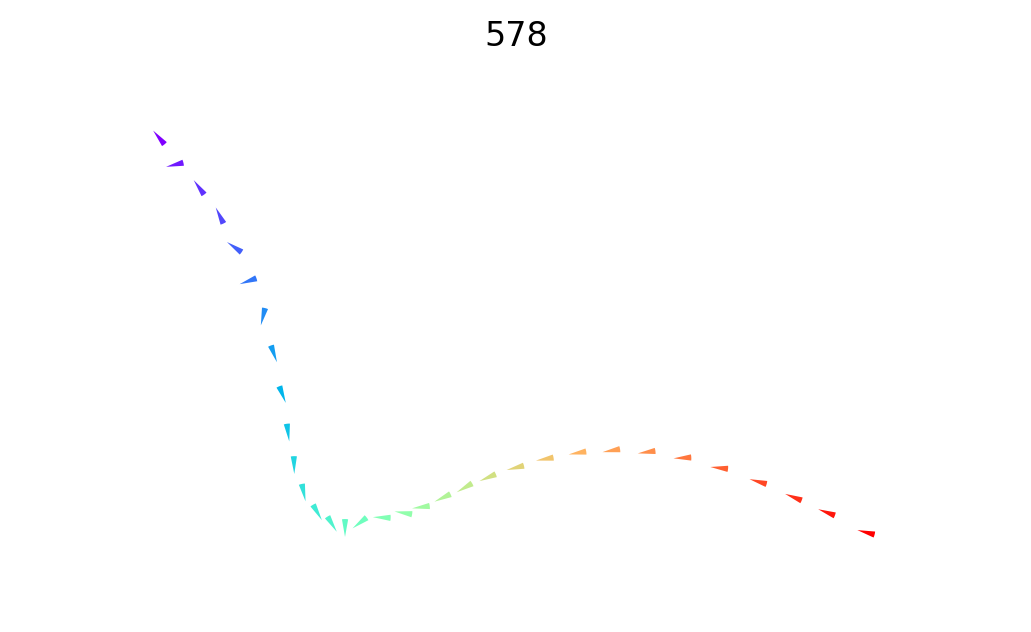

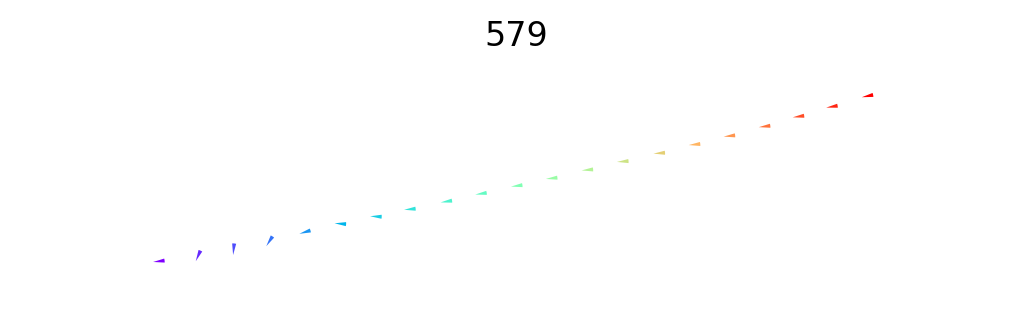

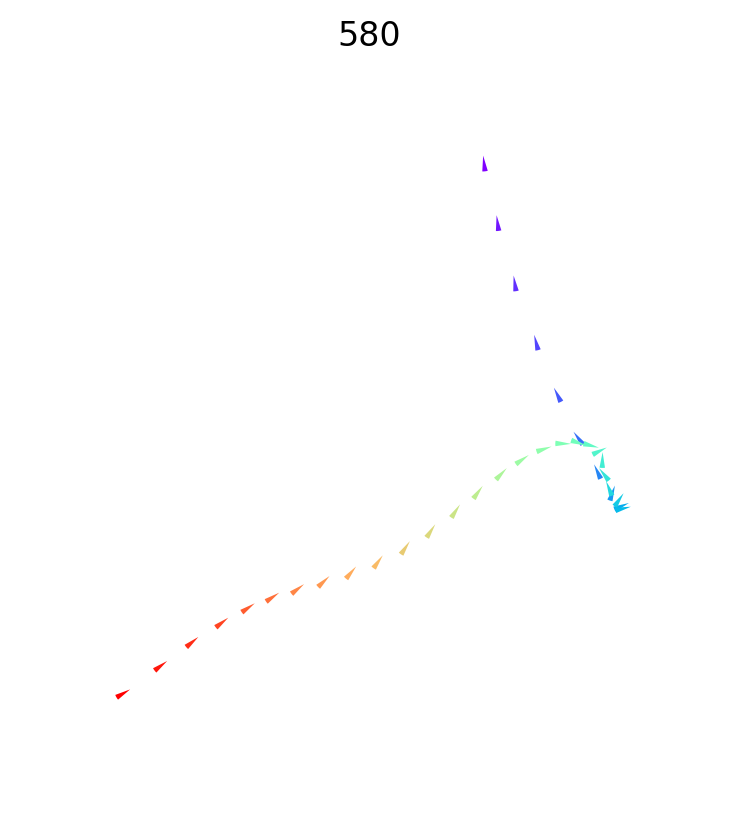

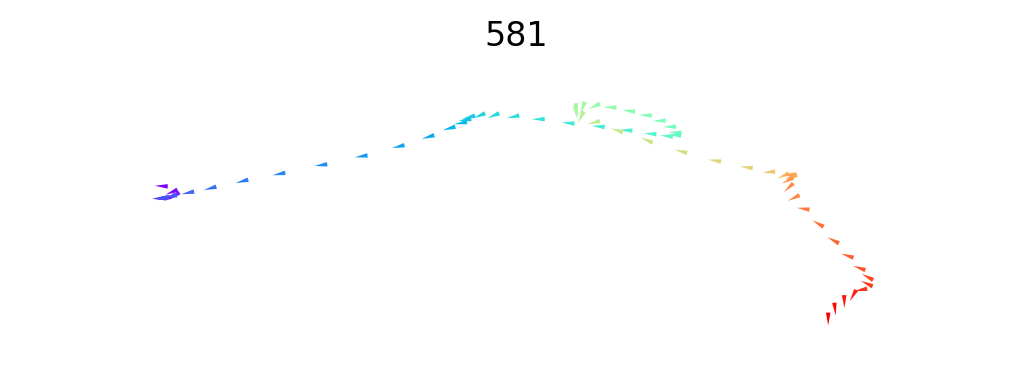

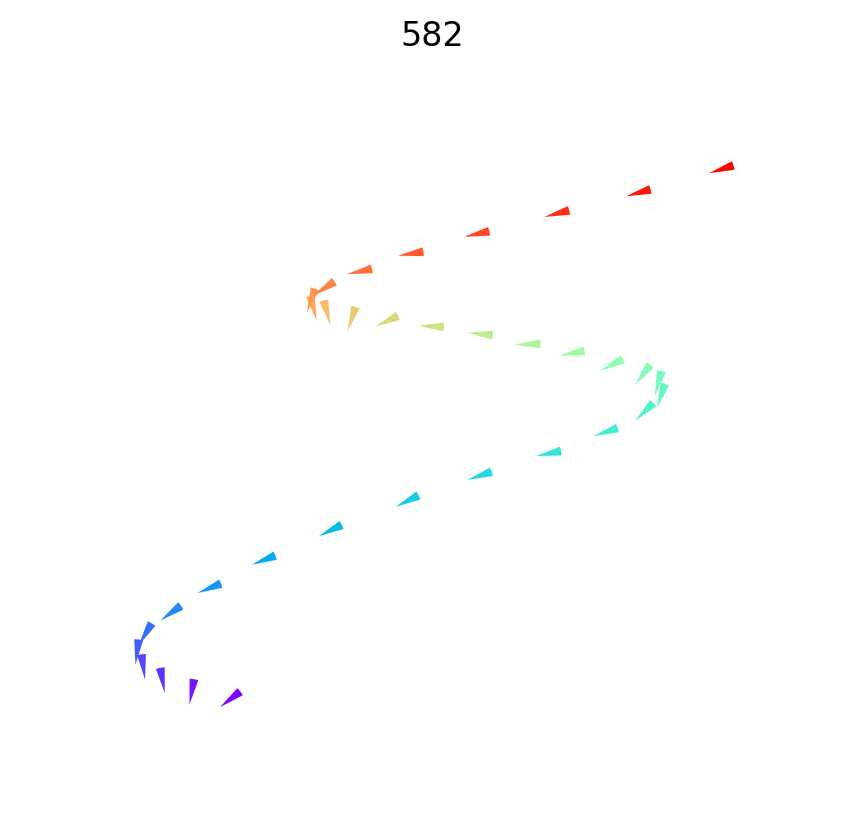

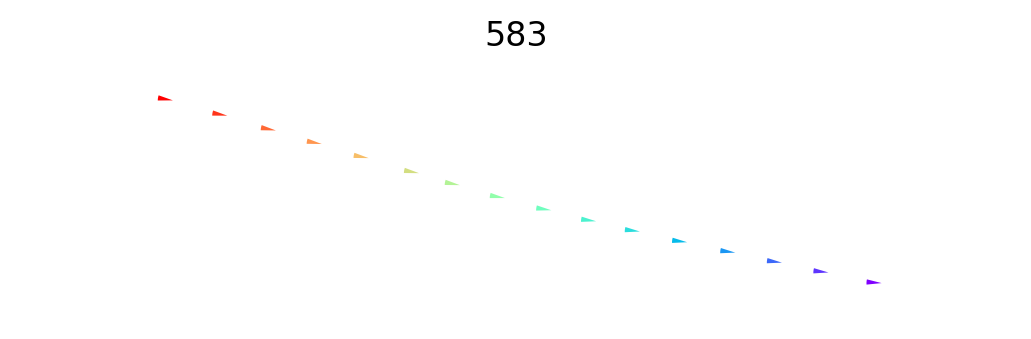

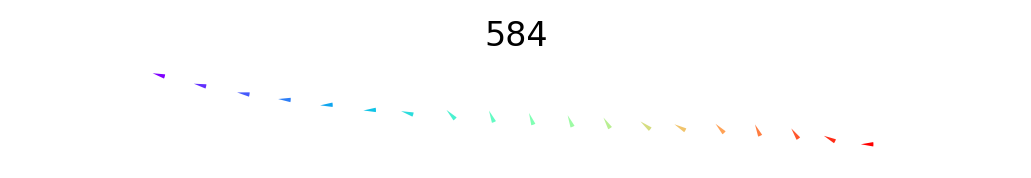

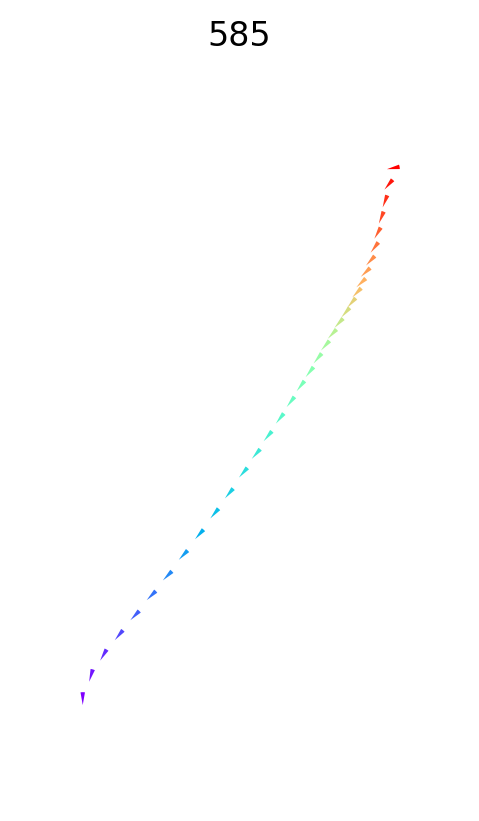

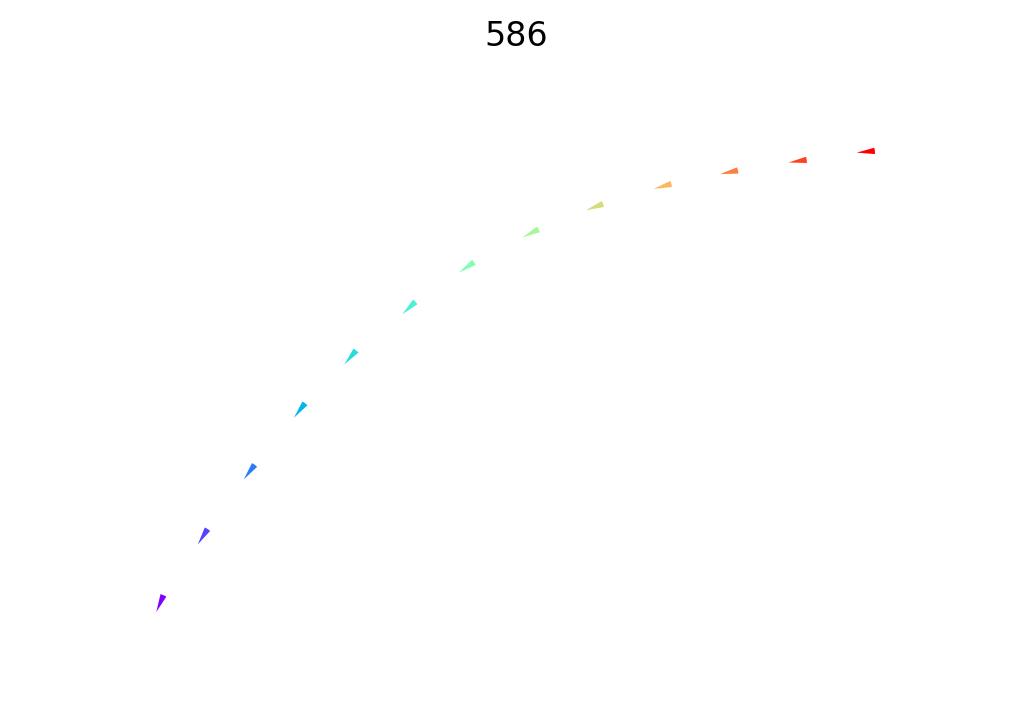

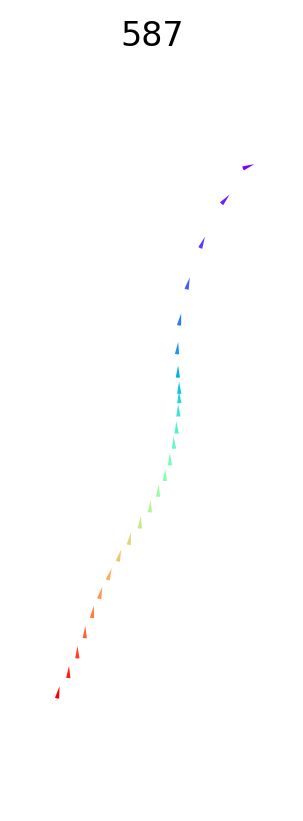

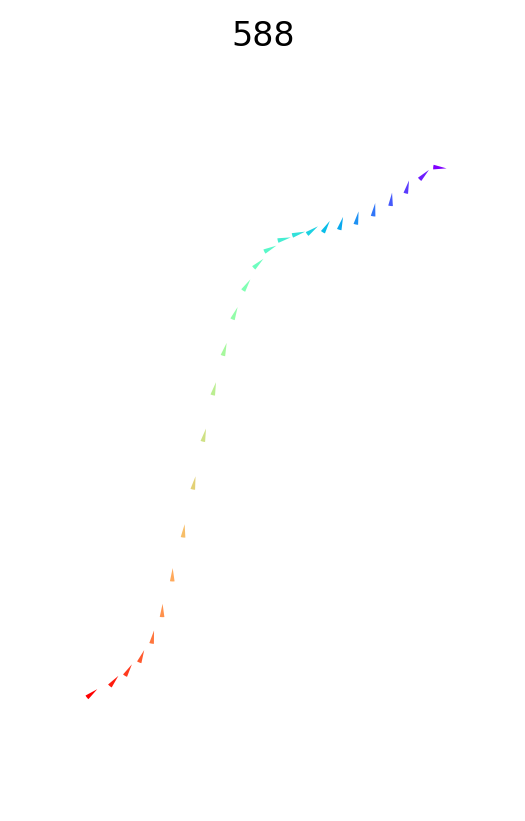

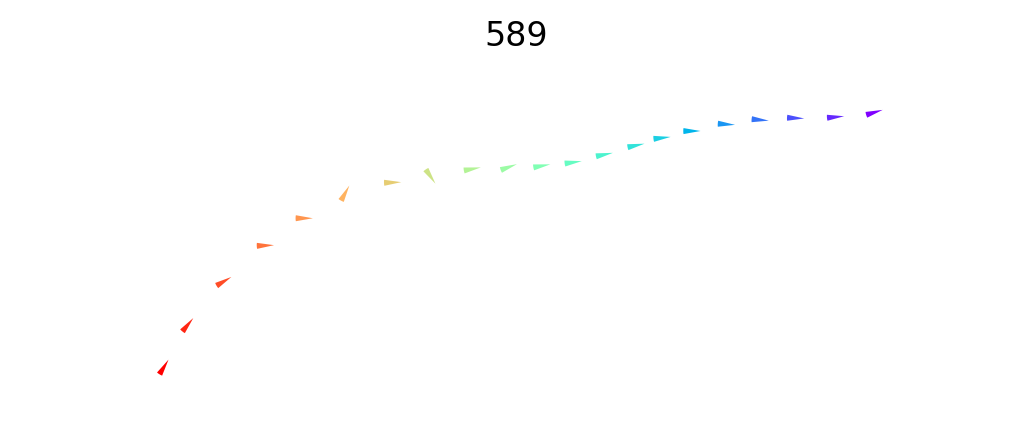

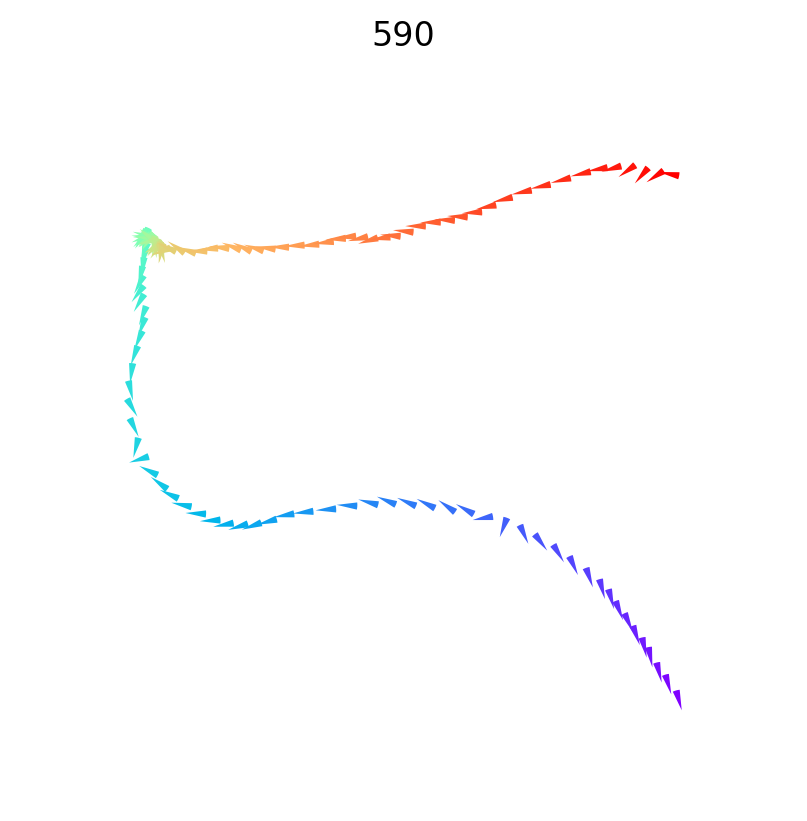

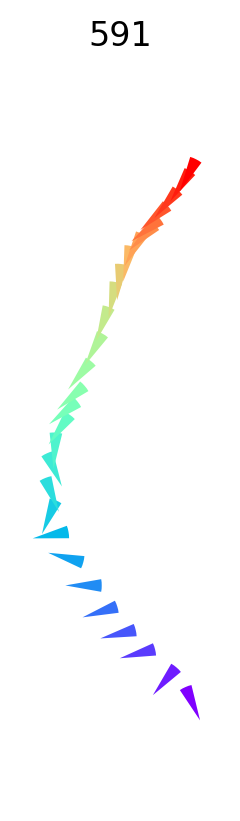

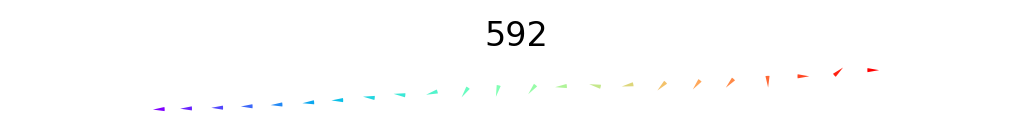

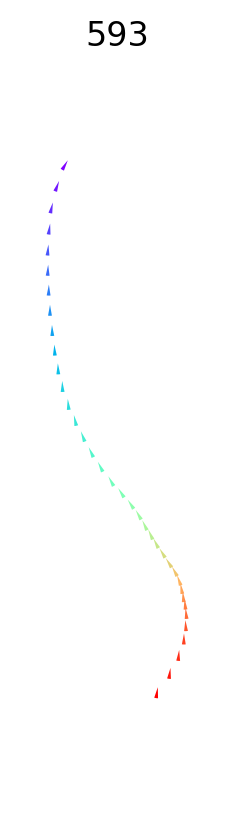

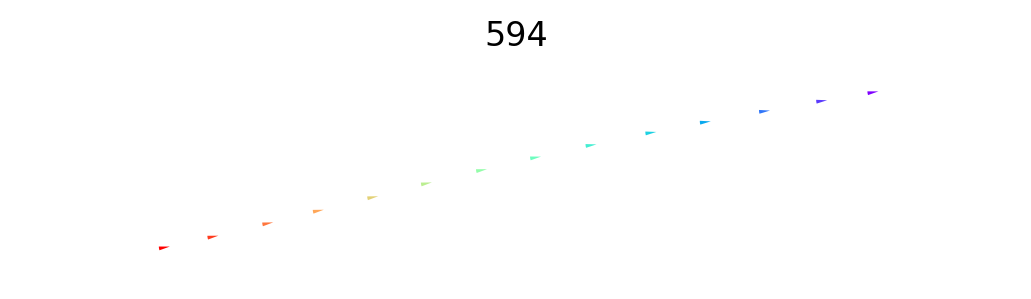

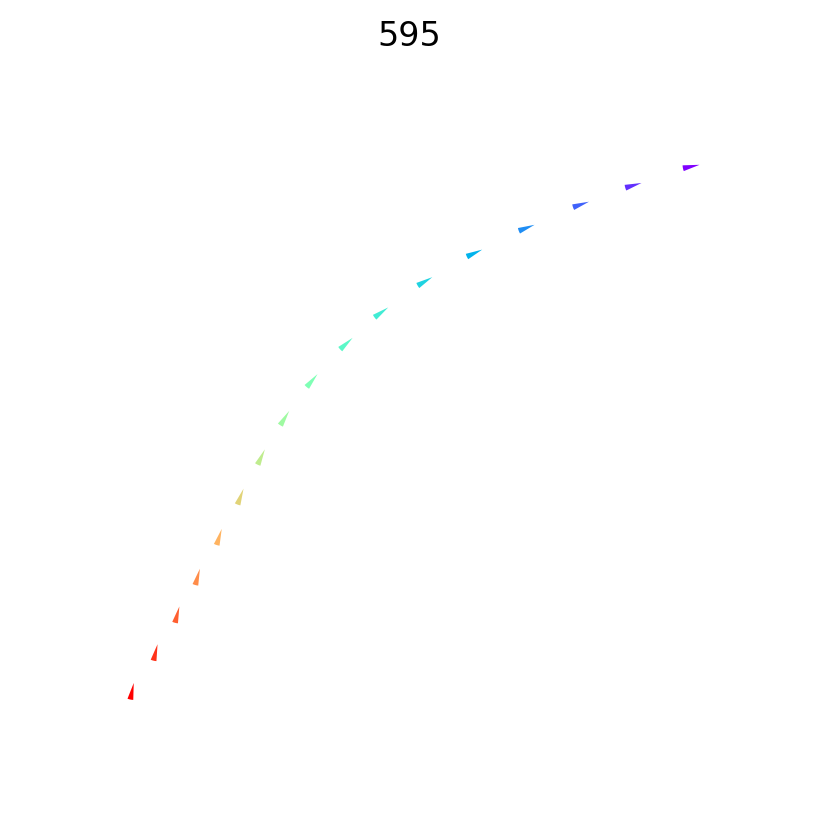

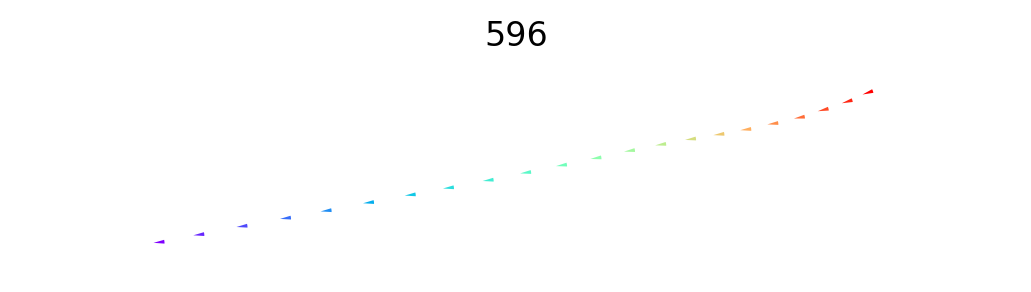

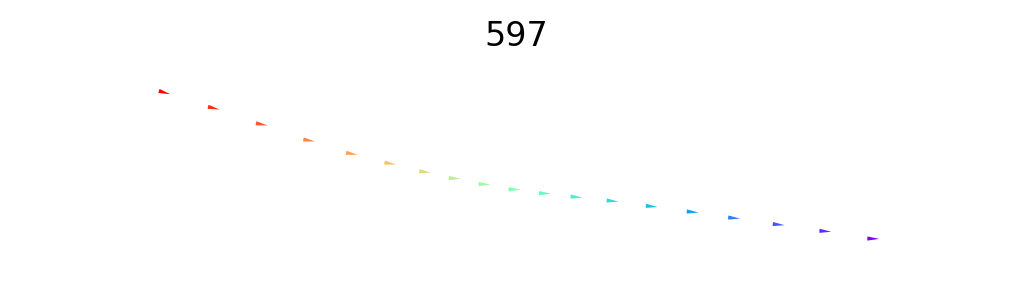

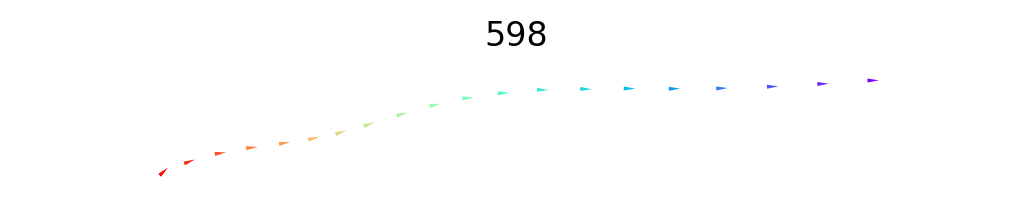

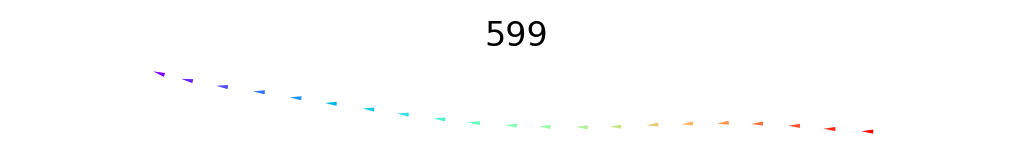

In [12]:
for k in range(500, 600):
    traj = traj_add_list[k]

    fig, ax = plt.subplots(dpi=200)
    
    x = traj['position_x'].values.copy()
    y = traj['position_y'].values.copy()    
    x = x - np.mean(x)
    y = y - np.mean(y)
    
    heading = traj['heading'].values 
    # heading = traj['course_direction'].values
    
    ff.plot_trajectory(x, y, heading, traj.time.values, ax=ax, size_radius=10, nskip=0, colormap='rainbow_r')
    
    ax.set_title(k)
    
    fifi.mpl_functions.adjust_spines(ax, [])